<b>Credit Card Project Part I: Machine Learning</b>

This project uses credit card data for 30,000 anonymous credit card clients in Taiwan. It presents information on the customers (education, sex, marital status, age) and their behavior for a six-month period from April 2005 to September 2005. The information was [downloaded in CSV format from Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset), and according to the information provided it was uploaded from the UC Irvine Machine Learning Repository.

<b>Part I</b>, presented here, provides an opportunity to practice using Machine Learning algorithms and Feature Engineering. [<b>Part II</b>](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_part_II.ipynb) provides an opportunity to practice running statistical tests and simulations. [A PowerPoint summary](https://www.dropbox.com/sh/38tcjlw7gb7bvka/AABsPtsNWq7yXZpuBqO1-_qNa?dl=0) of this project is also available. [<b>Part III</b>](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_Part_III.ipynb) trains a model that sacrifices performance for interpretability. Part IV will be up soon.

<b>Goals</b>

After cursory exploration of this data, I decided that it's primary value in a Machine Learning context is that it provides a chance to practice and think about <b>Feature Engineering</b>. As will become clear, many of the features provided mix different kinds of information. Some features, for example, mix quantitative data with categorial data. In other cases, the provided features show low correlations with the target value, but one can easily derive new features with much higher correlations with the target value.

I will train various Machine Learning models to solve an obvious classification problem: predicting which credit card customers will default. Models will be evaluated in terms of performance--primarily measured by their ROC AUC score. A random forest model turns out to have the best performance, even without feature engineering. A logistic regression model performs nearly as well, but only after substantial feature engineering.

The project also raises questions about how to interpret <b>questionable data.</b> I will identify some of the possible problems with the data as the project progresses, and offer some thoughts on how these problems might change our interpretation of the machine learning data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

starting_data = pd.read_csv("https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/UCI_Credit_Card.csv?raw=True")

len(starting_data)

30000

Because the credit card data contains 30000 samples, we can afford to set some aside as the final test dataset. I will separate this data (15%) from the rest now. I will not look at it or use it for model selection. It will be used to test the performance of the final models.

In [2]:
hermetically_sealed_data = starting_data.sample(n=4500, replace=False, random_state=177)

starting_data = starting_data[~starting_data.index.isin(hermetically_sealed_data.index)]

In [3]:
len(starting_data), len(hermetically_sealed_data)

(25500, 4500)

<b>Looking at the Data</b>

In [5]:
starting_data.head(25)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    1    20000.0    2          2         1   24      2      2     -1     -1   
1    2   120000.0    2          2         2   26     -1      2      0      0   
3    4    50000.0    2          2         1   37      0      0      0      0   
4    5    50000.0    1          2         1   57     -1      0     -1      0   
5    6    50000.0    1          1         2   37      0      0      0      0   
6    7   500000.0    1          1         2   29      0      0      0      0   
7    8   100000.0    2          2         2   23      0     -1     -1      0   
8    9   140000.0    2          3         1   28      0      0      2      0   
11  12   260000.0    2          1         2   51     -1     -1     -1     -1   
12  13   630000.0    2          2         2   41     -1      0     -1     -1   
13  14    70000.0    1          2         2   30      1      2      2      0   
14  15   250000.0    1          1         2   29      0      0      0      0   
16  17    20000.0    1          1         2   24      0      0      2      2   
17  18   320000.0    1          1         1   49      0      0      0     -1   
18  19   360000.0    2          1         1   49      1     -2     -2     -2   
19  20   180000.0    2          1         2   29      1     -2     -2     -2   
20  21   130000.0    2          3         2   39      0      0      0      0   
21  22   120000.0    2          2         1   39     -1     -1     -1     -1   
23  24   450000.0    2          1         1   40     -2     -2     -2     -2   
25  26    50000.0    1          3         2   23      0      0      0      0   
26  27    60000.0    1          1         2   27      1     -2     -1     -1   
27  28    50000.0    2          3         2   30      0      0      0      0   
28  29    50000.0    2          3         1   47     -1     -1     -1     -1   
30  31   230000.0    2          1         2   27     -1     -1     -1     -1   
31  32    50000.0    1          2         2   33      2      0      0      0   

    ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0   ...        0.0        0.0        0.0       0.0     689.0       0.0   
1   ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
3   ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4   ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   
5   ...    19394.0    19619.0    20024.0    2500.0    1815.0     657.0   
6   ...   542653.0   483003.0   473944.0   55000.0   40000.0   38000.0   
7   ...      221.0     -159.0      567.0     380.0     601.0       0.0   
8   ...    12211.0    11793.0     3719.0    3329.0       0.0     432.0   
11  ...     8517.0    22287.0    13668.0   21818.0    9966.0    8583.0   
12  ...     6500.0     6500.0     2870.0    1000.0    6500.0    6500.0   
13  ...    66782.0    36137.0    36894.0    3200.0       0.0    3000.0   
14  ...    59696.0    56875.0    55512.0    3000.0    3000.0    3000.0   
16  ...    18338.0    17905.0    19104.0    3200.0       0.0    1500.0   
17  ...    70074.0     5856.0   195599.0   10358.0   10000.0   75940.0   
18  ...        0.0        0.0        0.0       0.0       0.0       0.0   
19  ...        0.0        0.0        0.0       0.0       0.0       0.0   
20  ...    20616.0    11802.0      930.0    3000.0    1537.0    1000.0   
21  ...        0.0      632.0      316.0     316.0     316.0       0.0   
23  ...      560.0        0.0        0.0   19428.0    1473.0     560.0   
25  ...    28967.0    29829.0    30046.0    1973.0    1426.0    1001.0   
26  ...      -57.0      127.0     -189.0       0.0    1000.0       0.0   
27  ...    17878.0    18931.0    19617.0    1300.0    1300.0    1000.0   
28  ...     2040.0    30430.0      257.0    3415.0    3421.0    2044.0   
30  ...    15339.0    14307.0    36923.0   17270.0   13281.0   15339.0   
31  ...    22734.0    23217.0    23680.0    1718.0    1500.0    1000.0   

<b>Some Information on the Columns</b>

The following information about the columns was provided to accompany the Kaggle Dataset.

There are 25 variables:

•	ID: ID of each client

•	LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

•	SEX: Gender (1=male, 2=female)

•	EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

•	MARRIAGE: Marital status (1=married, 2=single, 3=others)

•	AGE: Age in years

•	PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

•	PAY_2: Repayment status in August, 2005 (scale same as above)

•	PAY_3: Repayment status in July, 2005 (scale same as above)

•	PAY_4: Repayment status in June, 2005 (scale same as above)

•	PAY_5: Repayment status in May, 2005 (scale same as above)

•	PAY_6: Repayment status in April, 2005 (scale same as above)

•	BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

•	BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

•	BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

•	BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

•	BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

•	BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

•	PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

•	PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

•	PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

•	PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

•	PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

•	PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

•	default.payment.next.month: Default payment (1=yes, 0=no)

<b>Additional Information on the Columns</b>

The information provided above is incomplete. For example, some of the PAY_{X} values are -2, but the meaning of -2 is not given above.

Fortunately, the discussion section for this Kaggle dataset provides additional information about the columns and values. (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608)

>I emailed the professor who created the data set. Listed here
>Below is the response regarding the values used for fields X6:X11
>
>>"This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
>>
>>X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
>>
>>X2: Gender (1 = male; 2 = female).
>>
>>X3: Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).
>>
>>X4: Marital status (1 = married; 2 = single; 3 = divorce; 0=others).
>>
>>X5: Age (year).
>>
>>X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is:
>>
>>-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
>>
>>X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
>>
>>X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
>>
>>Y: client's behavior; Y=0 then not default, Y=1 then default"

I will address some remaining difficulties with the data in a moment.

An obvious Machine Learning task with this data is to design a classification model that predicts whether credit card users will default. Let's start by looking at the default rate and surrounding information. Then we can look at some other aspects of the data. The basic goal here is a <b>sanity check</b>. Does this data look right, or are some aspects of it confusing or hard to believe? I will also check for missing and duplicate values, etc.

In [6]:
starting_data["default.payment.next.month"].describe()
#22.2% default rate!

count    25500.000000
mean         0.221569
std          0.415310
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default.payment.next.month, dtype: float64

In [7]:
starting_data.AGE.describe()

count    25500.000000
mean        35.483451
std          9.218687
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [8]:
starting_data.LIMIT_BAL.describe()

count     25500.000000
mean     167583.516863
std      129983.164240
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      240000.000000
max      800000.000000
Name: LIMIT_BAL, dtype: float64

<IPython.core.display.Javascript object>


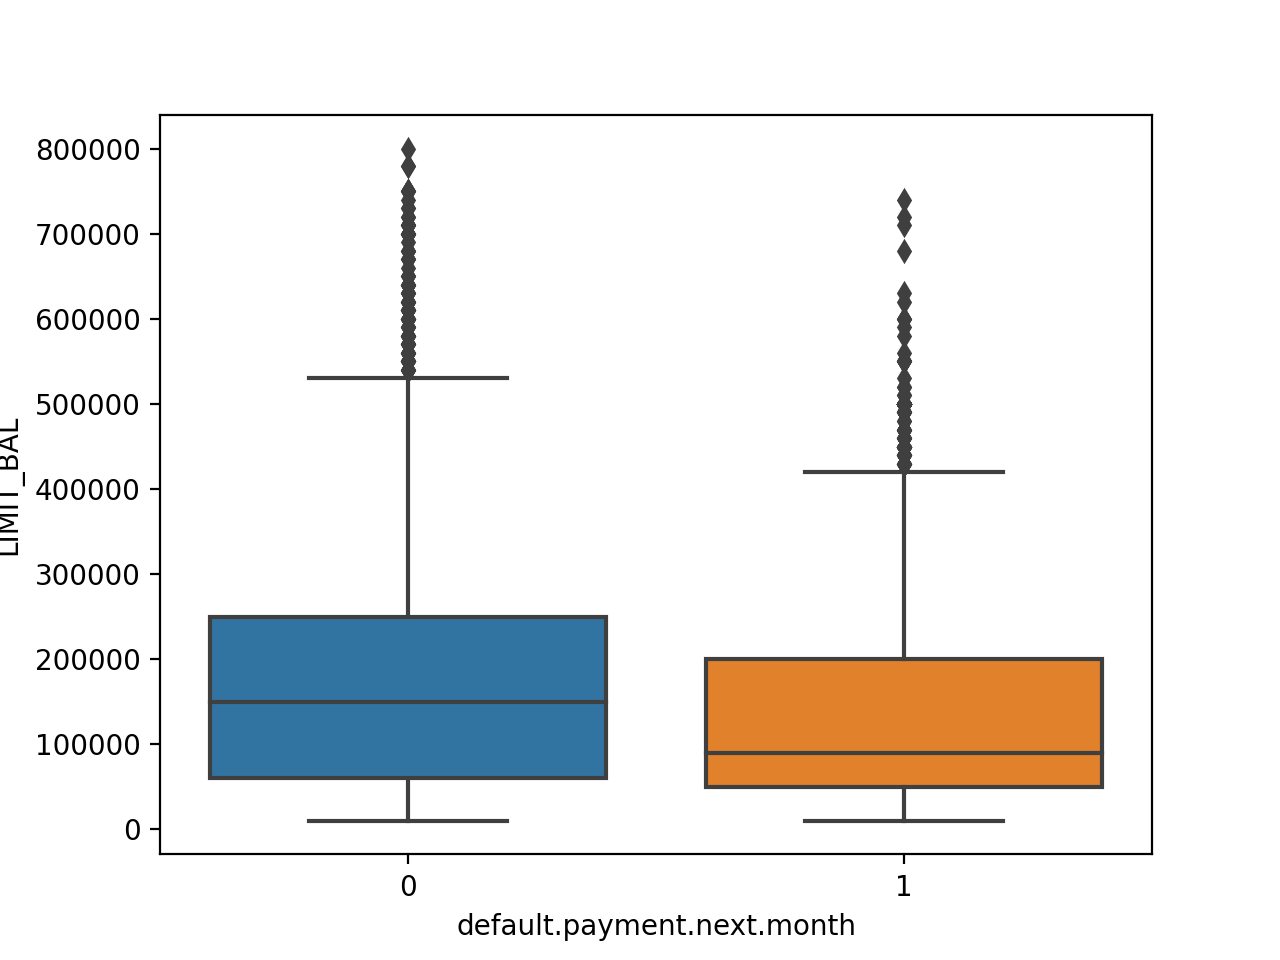

<AxesSubplot:xlabel='default.payment.next.month', ylabel='LIMIT_BAL'>

In [9]:
%matplotlib notebook
sns.boxplot(data=starting_data, x="default.payment.next.month", y="LIMIT_BAL")

In [10]:
starting_data.isna().sum()

#No missing data.

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [11]:
#no duplicated data

sum(starting_data.duplicated())

0

In [12]:
#60.4% of customers are women

(starting_data.SEX - 1).mean()

0.6042352941176471

In [13]:
#46.9% went to university; 35.3% went to graduate school

starting_data.EDUCATION.value_counts()/len(starting_data)

2    0.468353
1    0.352784
3    0.164039
5    0.008784
4    0.004039
6    0.001647
0    0.000353
Name: EDUCATION, dtype: float64

In [14]:
starting_data[["PAY_0", "default.payment.next.month"]].corr()

PAY_0  default.payment.next.month
PAY_0                       1.000000                    0.322502
default.payment.next.month  0.322502                    1.000000

<b>Potential Problems with the Data</b>

While some aspects of the data make sense (there is a moderate correlation between how many months behind a customer was in September and whether they defaulted in the following month), some of it is surprising, and in some cases doesn't even seem to make sense.

<b>- Missing Late Payments:</b> In a few cases, the customers seem to jump from being on time with their payments to being several months late rather than only one month. For example, in row 0 the customer is paid in full in August 2005 (e.g., PAY_2), but skips to being two months late in September 2005 (PAY_0). Remember that PAY_1 is not used. How does a customer become two months behind in payments in the span of a single month? Also see rows 8, 13 and 31. This may represent mistakes in recording the data.

<b>- Percentage of Defaults:</b> Nearly 1/4 (22.2%) of the customers in our sample defaulted. I would imagine that any credit card company that saw an average of 22% of its customers default in a six-month period would quickly go out of business. After a quick internet search, I have failed to find anything that would explain why there might be an abnormally high default rate in this period. Taiwan experienced recessions in 2001 and 2008, but not, as far as I can tell, in 2005. <b>This dataset may not represent a random sample of credit card users.</b> It may be, for example, that these users were selected because they seemed more at risk. (Or something else weird is going on.)

<b>- Limit Balance:</b> While these numbers initially seem surprisingly high, they make more sense when we remember that they are given in New Taiwanese Dollars (NTDs). A cursory look indicates the exchange rate in 2005 was approximately 31 or 32 NTDs per USD, which makes the mean limit a little over 5000 USD. <b>This actually looks reasonable.</b>

<b>- Sex:</b> Over 60% of the customers are women. This is a bit more unbalanced than one would expect. Perhaps women are more likely to seem like responsible users of credit: the default rate for women is lower than that for men (see below).

<b>- Education:</b> These results again appear quite unbalanced. Nearly 47% of customers have gone to university, and 35% went to graduate school. According to Wikipedia, 45% of Taiwanese between the ages of 25 and 64 have a bachelors degree or higher. This is an impressive level of education in the general public, but 45% is considerably lower than 82%. Possibly more educated people are more likely to get credit cards (either because they are more likely to apply for them, or more likely to be approved, or both).

In [15]:
#comparing men and women's default rates and totals

starting_data.groupby("SEX")["default.payment.next.month"].agg(["mean", "sum"])

mean   sum
SEX                
1    0.243559  2458
2    0.207165  3192

<IPython.core.display.Javascript object>


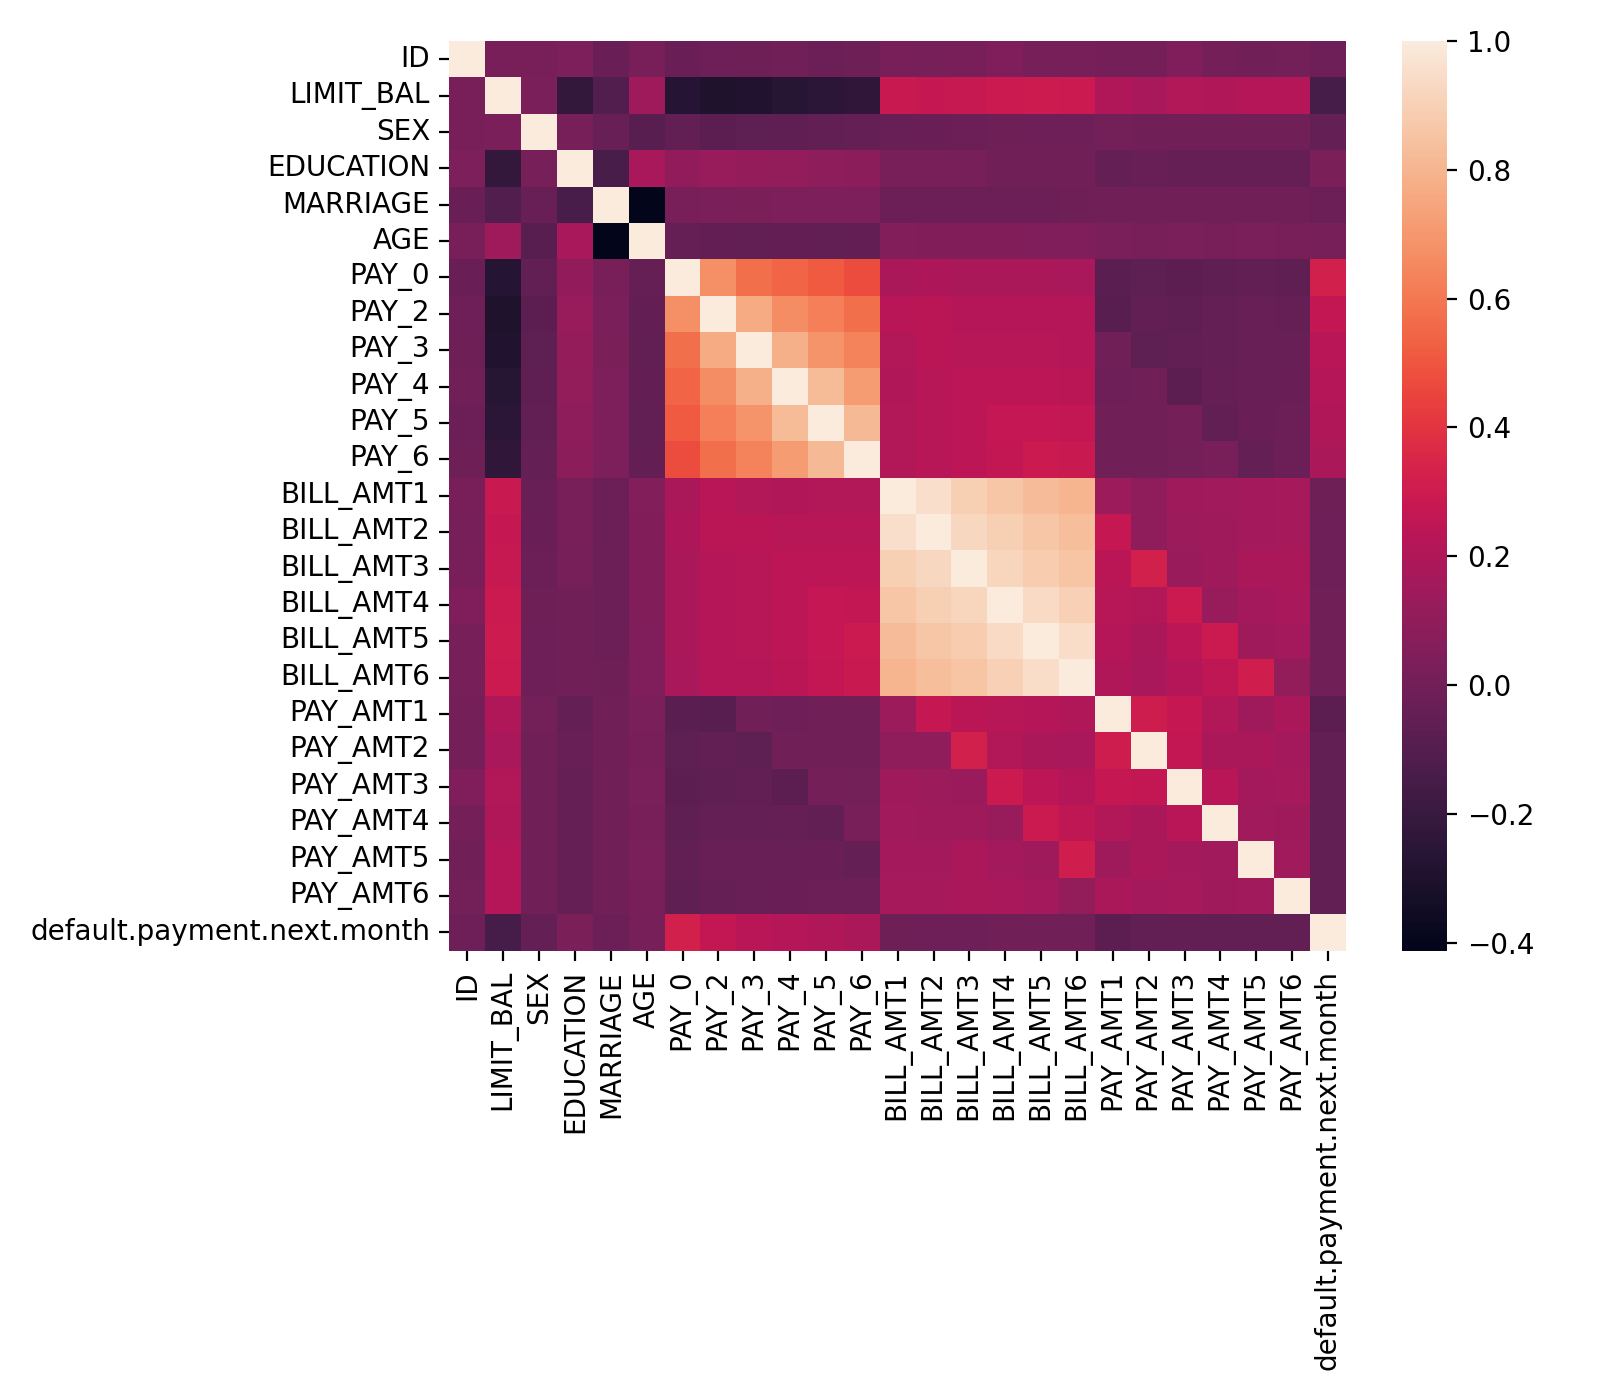

In [16]:
#checking basic correlations

x = starting_data.corr()

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(x, ax=ax)
plt.tight_layout()
#plt.savefig("heat_map.png", dpi=300)

The target variable has low to moderate levels of correlation with the X variables. There appears to be high levels of collinearity within the various PAY_{X} columns and also within the various BILL_AMT{X} columns.

In [17]:
pay_cols = ["PAY_0"] + [f"PAY_{x}" for x in range(2,7)]

bill_cols = [f"BILL_AMT{x}" for x in range(1, 7)]

starting_data[pay_cols].corr()

PAY_0     PAY_2     PAY_3     PAY_4     PAY_5     PAY_6
PAY_0  1.000000  0.669048  0.572576  0.538679  0.509718  0.472998
PAY_2  0.669048  1.000000  0.766788  0.664751  0.622802  0.574544
PAY_3  0.572576  0.766788  1.000000  0.779378  0.688775  0.633613
PAY_4  0.538679  0.664751  0.779378  1.000000  0.820265  0.717902
PAY_5  0.509718  0.622802  0.688775  0.820265  1.000000  0.817915
PAY_6  0.472998  0.574544  0.633613  0.717902  0.817915  1.000000

In [18]:
starting_data[bill_cols].corr()

BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6
BILL_AMT1   1.000000   0.951532   0.891515   0.858948   0.828069   0.798701
BILL_AMT2   0.951532   1.000000   0.927282   0.890710   0.858114   0.829414
BILL_AMT3   0.891515   0.927282   1.000000   0.922484   0.882116   0.853244
BILL_AMT4   0.858948   0.890710   0.922484   1.000000   0.939012   0.899655
BILL_AMT5   0.828069   0.858114   0.882116   0.939012   1.000000   0.945785
BILL_AMT6   0.798701   0.829414   0.853244   0.899655   0.945785   1.000000

In [19]:
#correlations with the target

starting_data.corr()["default.payment.next.month"]

ID                           -0.013606
LIMIT_BAL                    -0.151570
SEX                          -0.042854
EDUCATION                     0.031913
MARRIAGE                     -0.025076
AGE                           0.013946
PAY_0                         0.322502
PAY_2                         0.260948
PAY_3                         0.232896
PAY_4                         0.214586
PAY_5                         0.204806
PAY_6                         0.186775
BILL_AMT1                    -0.018550
BILL_AMT2                    -0.012532
BILL_AMT3                    -0.012635
BILL_AMT4                    -0.008435
BILL_AMT5                    -0.004651
BILL_AMT6                    -0.003857
PAY_AMT1                     -0.075714
PAY_AMT2                     -0.058302
PAY_AMT3                     -0.057904
PAY_AMT4                     -0.056626
PAY_AMT5                     -0.058414
PAY_AMT6                     -0.054303
default.payment.next.month    1.000000
Name: default.payment.nex

<IPython.core.display.Javascript object>


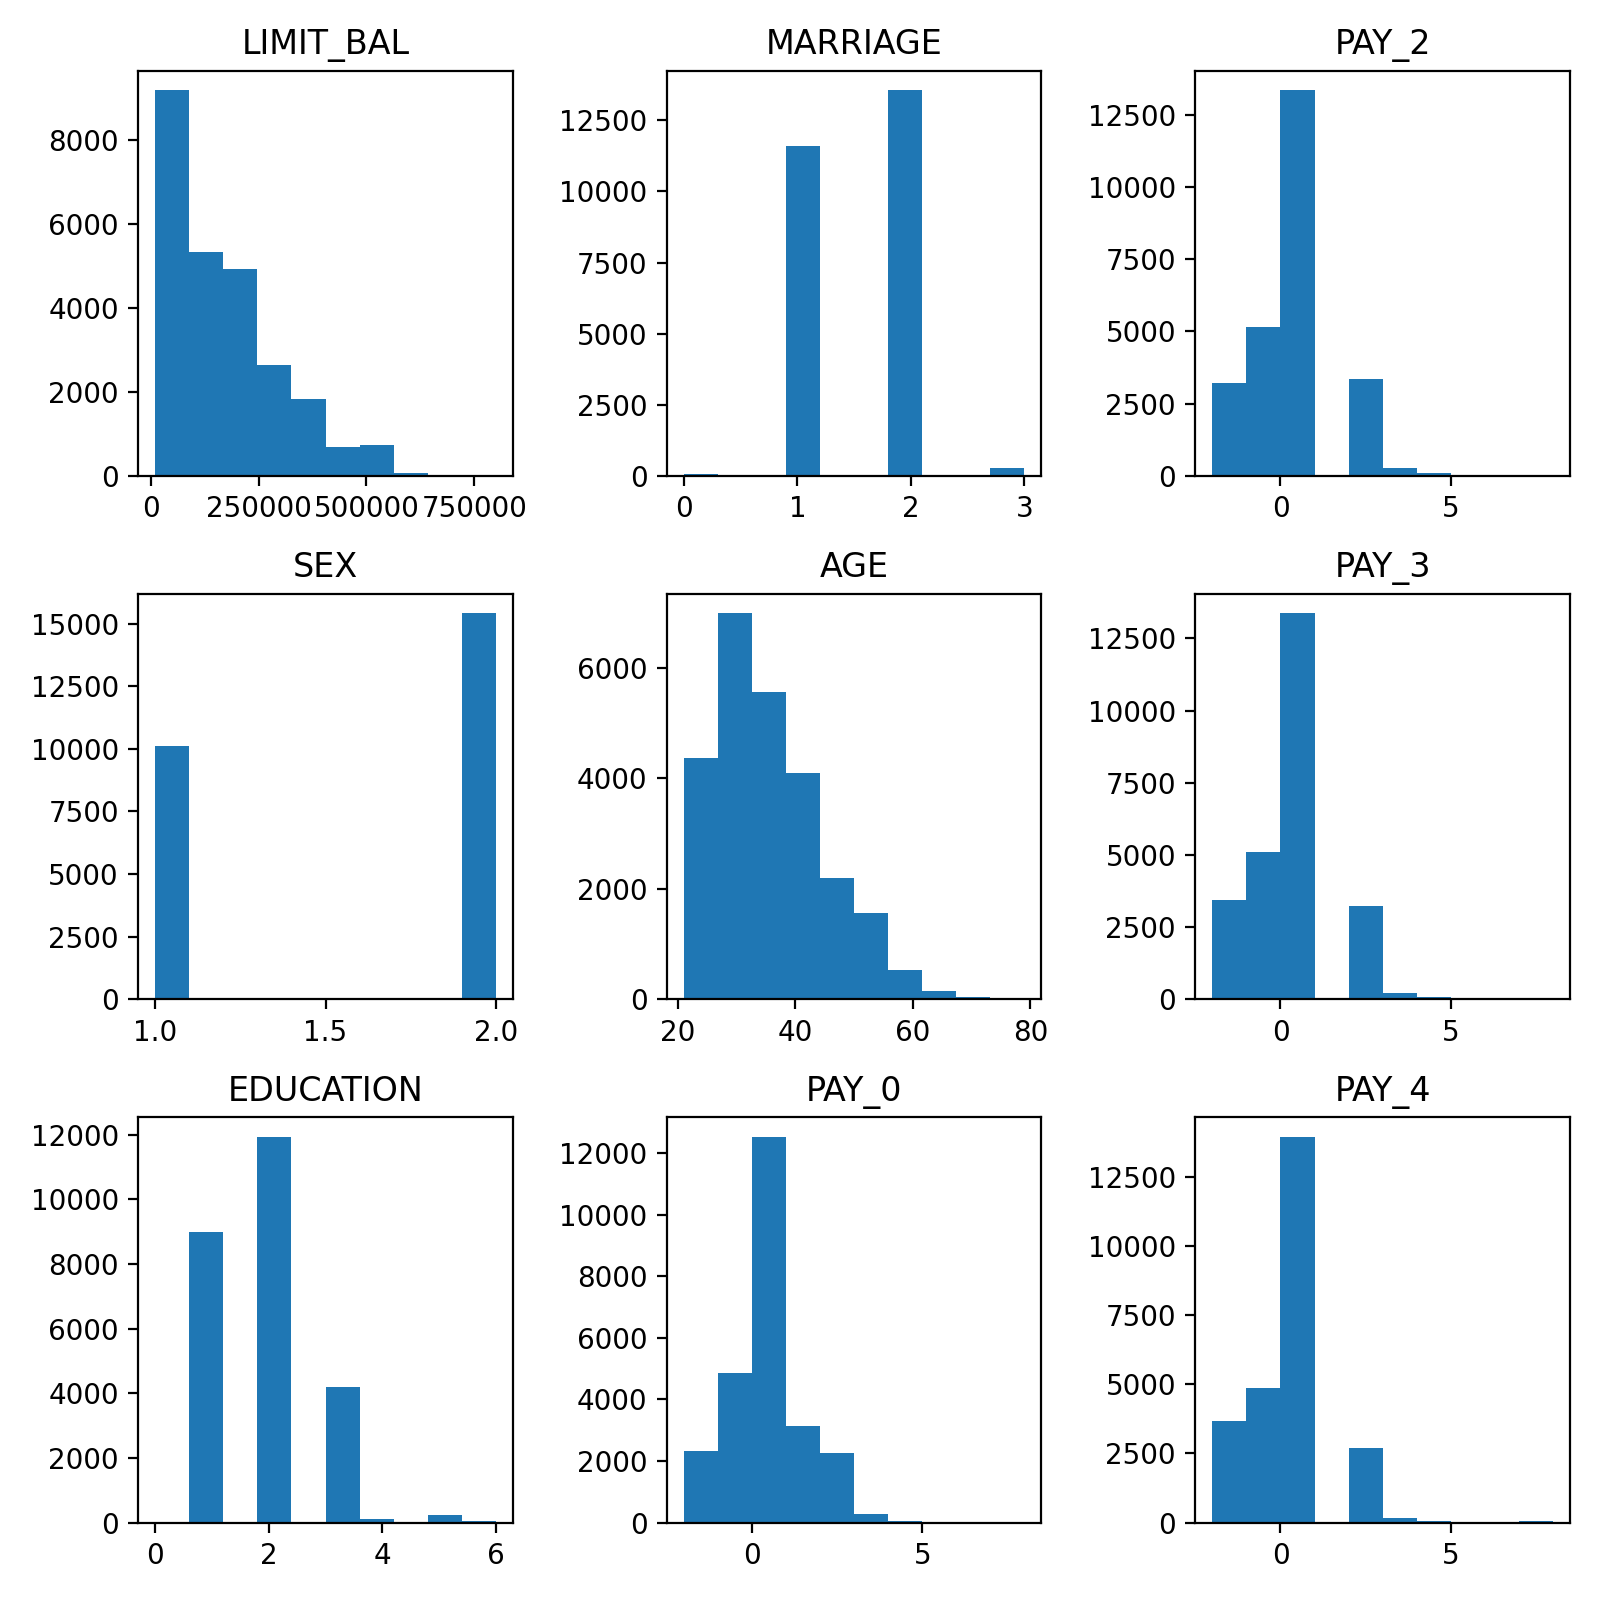

In [20]:
#How is the data distributed - First 9 columns (skipping ID)

fig, axes = plt.subplots(3, 3)
columns = starting_data.columns

fig.set_size_inches(8, 8)
for i in range(1, 10):
    axes[(i-1)%3, (i-1)//3].hist(starting_data[columns[i]])
    axes[(i-1)%3, (i-1)//3].title.set_text(columns[i])

plt.tight_layout()

<IPython.core.display.Javascript object>


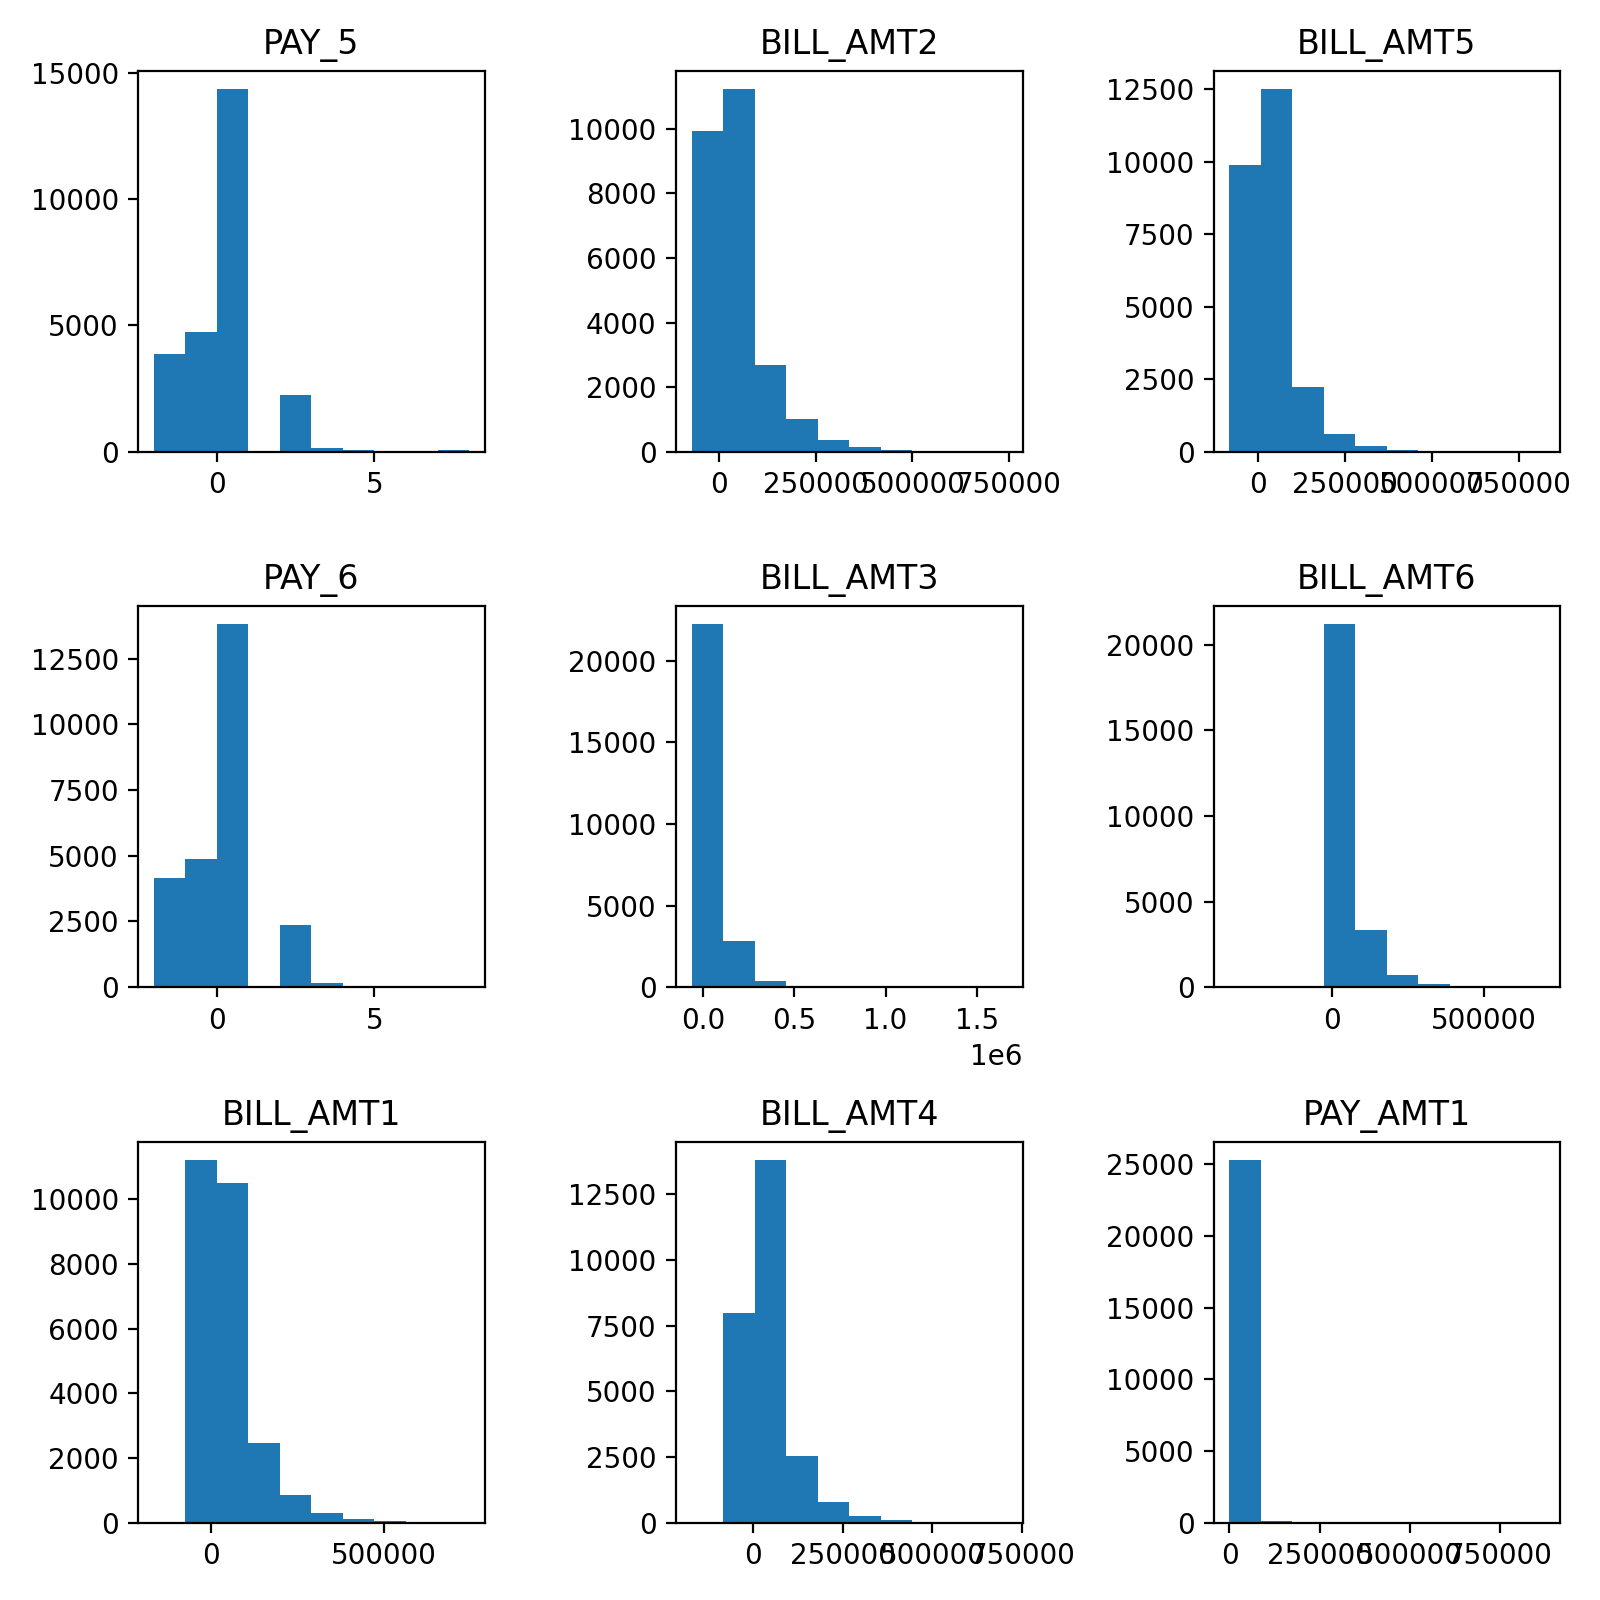

In [21]:
#Next 9 columns

fig, axes = plt.subplots(3, 3)
columns = starting_data.columns

fig.set_size_inches(8, 8)
for i in range(10, 19):
    axes[(i-10)%3, (i-10)//3].hist(starting_data[columns[i]])
    axes[(i-10)%3, (i-10)//3].title.set_text(columns[i])

plt.tight_layout()

<IPython.core.display.Javascript object>


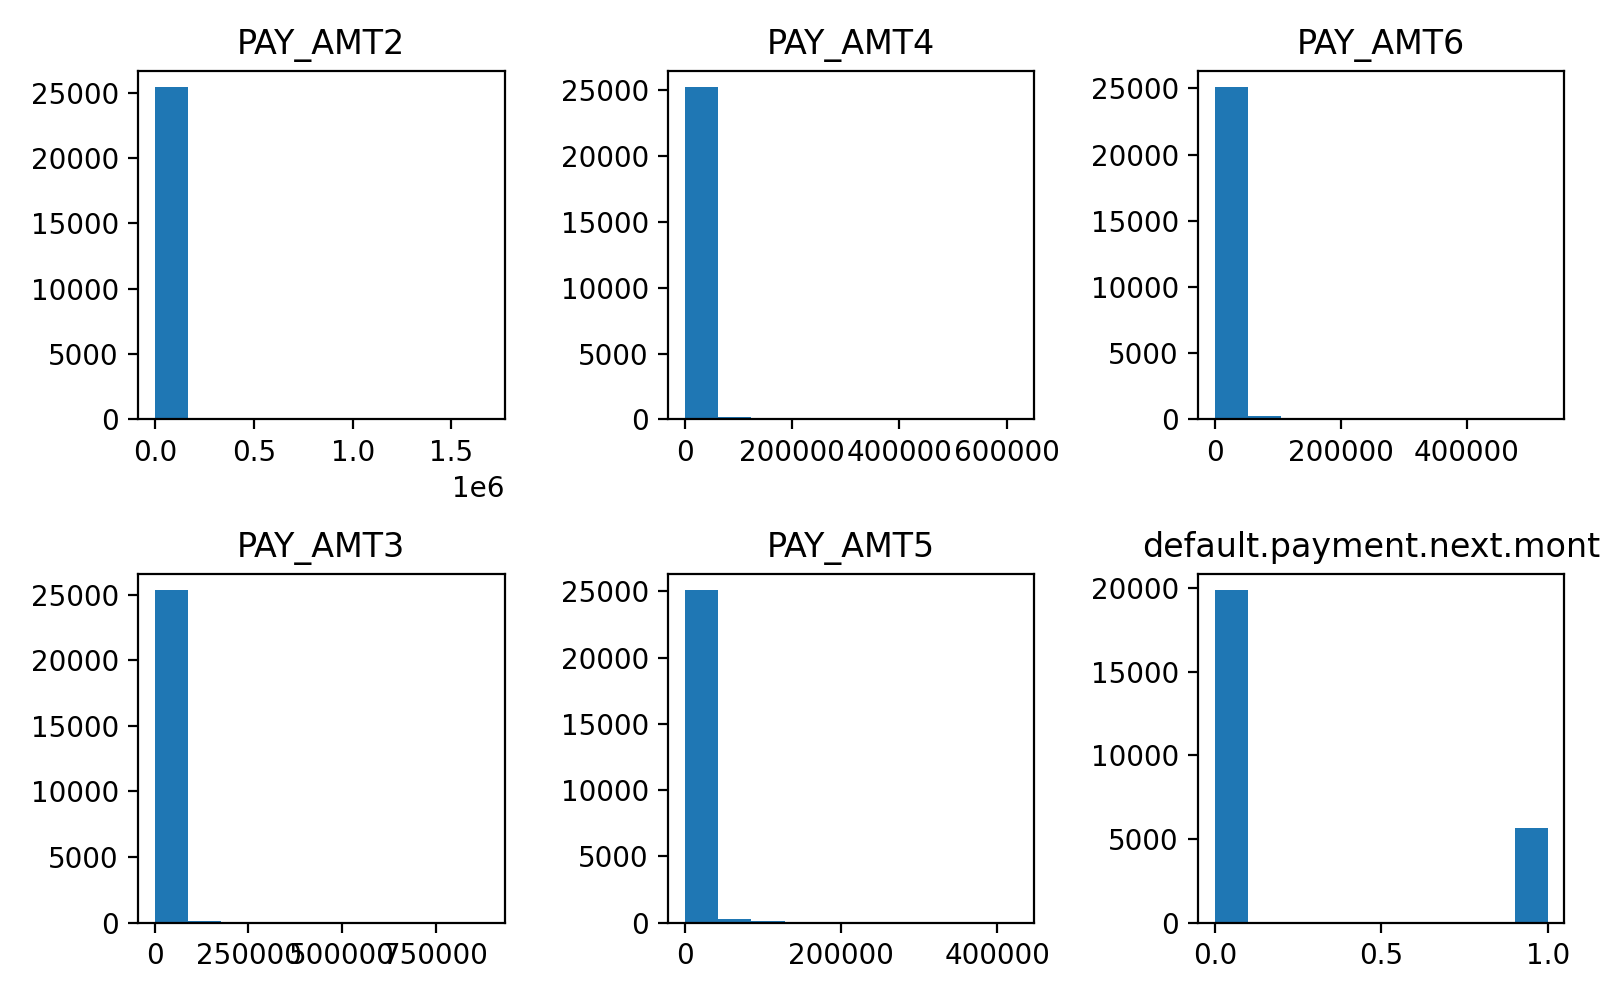

In [22]:
#final columns

fig, axes = plt.subplots(2, 3)
columns = starting_data.columns

fig.set_size_inches(8, 5)
for i in range(19, 25):
    axes[(i-19)%2, (i-19)//2].hist(starting_data[columns[i]])
    axes[(i-19)%2, (i-19)//2].title.set_text(columns[i])

plt.tight_layout()

<b>Baseline: Minimal Feature Engineering</b>

One of the main goals of this project is to practice feature engineering. In order to test how effective the feature engineering has been, I will first train models on the data provided with <b>minimal</b> feature engineering. This will provide a baseline against which to compare models trained after significantly more feature engineering.

<b>Model</b>

This is a classification problem with a large-ish dataset and a mixture of categorical and quantitative data. The most obvious classifier to use is Logistic Regression.

To keep things interesting, I'll also try a Random Forest.

<b>Necessary Preprocessing</b>

The idea here is to do all the preprocessing that can be done without thinking about it too much. Existing distributions are not normal. For the Logistic Regression, I will apply a Power Transformer to the quantitative data, scale the data, and put it through principal component analysis to reduce risk of collinearity. Anything that requires intelligence--i.e., thinking about what the data means--will wait.

The Random Forest will not require any preprocessing.

<b>Important</b>

Even though the gridsearch uses cross-validation to protect against overfitting, I will still split the data into a train and test set. I will be scaling data for the Logistic Regression Model, and separating test data beforehand will help protect against data leakage. It will also let me check the accuracy of the model on a test set--cross validation will only provide the mean ROC score.

<b>Scoring</b>

Because the target data is somewhat unbalanced, we will look at the tradeoff between false positives and true positives. Scoring will be primarily based on ROC. Accuracy will be looked at as a secondary form of model evaluation.

In [23]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
X = starting_data.drop(columns=["ID", "default.payment.next.month"])
y = starting_data["default.payment.next.month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)


In [25]:
numeric_data = ["LIMIT_BAL", "AGE"] + pay_cols + bill_cols + [f"PAY_AMT{x}" for x in range(1, 7)]

transformer = PowerTransformer()

X_train_trans = X_train.copy()
X_train_trans[numeric_data] = transformer.fit_transform(X_train_trans[numeric_data])

#for x in numeric_data:
    #print(x)
    #plt.hist(X_train_trans[x])
    #plt.show()
    #plt.clf()

In [26]:
scaler = StandardScaler()
pca = PCA(.99)

X_train_scaled = scaler.fit_transform(X_train_trans)
X_train_pca = pca.fit_transform(X_train_scaled)

pca.explained_variance_ratio_

array([0.32943453, 0.17127128, 0.07474545, 0.06505848, 0.04452951,
       0.04103794, 0.03241501, 0.02831102, 0.02674213, 0.02568588,
       0.02472843, 0.02291181, 0.02163499, 0.02049796, 0.01609796,
       0.01371898, 0.00852139, 0.00757798, 0.00633605, 0.00583353,
       0.0048425 ])

In [27]:
#2 dimensions of the PCA contained less than 1% of the information.

len(X.columns)

23

In [28]:
lr = LogisticRegression(solver="saga", random_state=17)
grid_params = {"penalty": ["l1", "l2"], "C":[.001, .01, .1, 1, 10, 100, 1000], "class_weight": [None, "balanced"]}
gridsearch = GridSearchCV(estimator=lr, param_grid=grid_params, scoring="roc_auc")

In [29]:
gridsearch.fit(X_train_pca, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=17, solver='saga'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [30]:
gridsearch.cv_results_

{'mean_fit_time': array([0.0620842 , 0.06854548, 0.06322355, 0.08436704, 0.08015823,
        0.15347538, 0.07887778, 0.14681077, 0.23121071, 0.22561774,
        0.15084519, 0.16994534, 0.24846025, 0.22753863, 0.18980794,
        0.18091946, 0.26380534, 0.26256175, 0.22302957, 0.20189142,
        0.29602537, 0.25808268, 0.2159225 , 0.21316695, 0.30431647,
        0.25096741, 0.22640853, 0.20527849]),
 'std_fit_time': array([0.00741747, 0.00567315, 0.0072245 , 0.0198614 , 0.00537904,
        0.01232599, 0.01089099, 0.01823011, 0.05156823, 0.05152711,
        0.03503116, 0.03608568, 0.05634369, 0.05038588, 0.04372026,
        0.0422395 , 0.04636765, 0.05443501, 0.05227702, 0.05782475,
        0.05803757, 0.06789373, 0.06374373, 0.04279115, 0.06241663,
        0.06548279, 0.05359529, 0.05341044]),
 'mean_score_time': array([0.00230303, 0.00233183, 0.00218792, 0.00465455, 0.00553236,
        0.00253797, 0.00306764, 0.00293121, 0.0024323 , 0.0026886 ,
        0.00224848, 0.00226445, 0.002277

In [44]:
best = gridsearch.best_params_
best_score = gridsearch.score(X_train_pca, y_train)

print(f"The best parameters are {best} with an roc_auc of {best_score}")

The best parameters are {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'} with an roc_auc of 0.7484631930158119


In [45]:
#Checking accuracy on Training Data

y_hat = gridsearch.predict(X_train_pca)

np.mean(y_hat == y_train)

0.7076078431372549

In [46]:
#Checking roc_auc for Test Data

X_test_trans = X_test.copy()
X_test_trans[numeric_data] = transformer.transform(X_test_trans[numeric_data])

X_test_scale = scaler.transform(X_test_trans)
X_test_pca = pca.transform(X_test_scale)

gridsearch.score(X_test_pca, y_test)

0.7367778159659729

In [47]:
#Checking accuracy for Test Data

y_hat2 = gridsearch.predict(X_test_pca)

np.mean(y_hat2 == y_test)

0.7002352941176471

In [48]:
#Let's try the random forest

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=93)
grid_params2 = {"max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18], "class_weight": [None, "balanced"]}

gridsearch2 = GridSearchCV(estimator=classifier, param_grid=grid_params2, scoring="roc_auc")

In [49]:
gridsearch2.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                              random_state=93),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18]},
             scoring='roc_auc')

In [50]:
gridsearch2.cv_results_

{'mean_fit_time': array([0.68218369, 0.76189818, 0.80628085, 0.83720179, 1.01348186,
        1.08633981, 1.15595102, 1.23617682, 1.23949981, 1.45518227,
        1.65122471, 0.68279505, 0.8753037 , 0.8940774 , 1.032162  ,
        0.98451171, 1.23696098, 1.39363236, 1.32026806, 1.48522072,
        2.06110864, 1.91883411]),
 'std_fit_time': array([0.03546012, 0.03804323, 0.04424803, 0.0087874 , 0.07732313,
        0.03042511, 0.05024113, 0.08517086, 0.0168675 , 0.04677171,
        0.06160225, 0.02046441, 0.10129594, 0.03614656, 0.10465869,
        0.0303941 , 0.04658972, 0.26301635, 0.09820267, 0.04801622,
        0.21118144, 0.13605785]),
 'mean_score_time': array([0.05691729, 0.06223001, 0.08201342, 0.05904236, 0.06430197,
        0.06684647, 0.06342478, 0.06173663, 0.06006722, 0.06308079,
        0.07041559, 0.05769773, 0.06831436, 0.06068621, 0.05911064,
        0.06014276, 0.06834073, 0.0661664 , 0.06036777, 0.06826773,
        0.12199702, 0.07536359]),
 'std_score_time': array([0.00

In [51]:
best = gridsearch2.best_params_
best_score = gridsearch2.score(X_train, y_train)

print(f"The best tree_depth is {best} with an roc_auc of {best_score}")

The best tree_depth is {'class_weight': None, 'max_depth': 11} with an roc_auc of 0.88979918665165


In [52]:
#accuracy on training data

np.mean(gridsearch2.predict(X_train)==y_train)

0.8726274509803922

In [53]:
#ROC area for test data
gridsearch2.score(X_test, y_test)

0.7871684887330861

In [54]:
#accuray on test data
np.mean(gridsearch2.predict(X_test)==y_test)

0.8144313725490196

In [55]:
#getting roc values

f_train_probs = gridsearch2.predict_proba(X_train)[:,1]
f_test_probs = gridsearch2.predict_proba(X_test)[:,1]

f_train_roc = roc_curve(y_train, f_train_probs)
f_test_roc = roc_curve(y_test, f_test_probs)

In [56]:
train_probs = gridsearch.predict_proba(X_train_pca)[:,1]
test_probs = gridsearch.predict_proba(X_test_pca)[:,1]

train_roc = roc_curve(y_train, train_probs)
test_roc = roc_curve(y_test, test_probs)

<IPython.core.display.Javascript object>


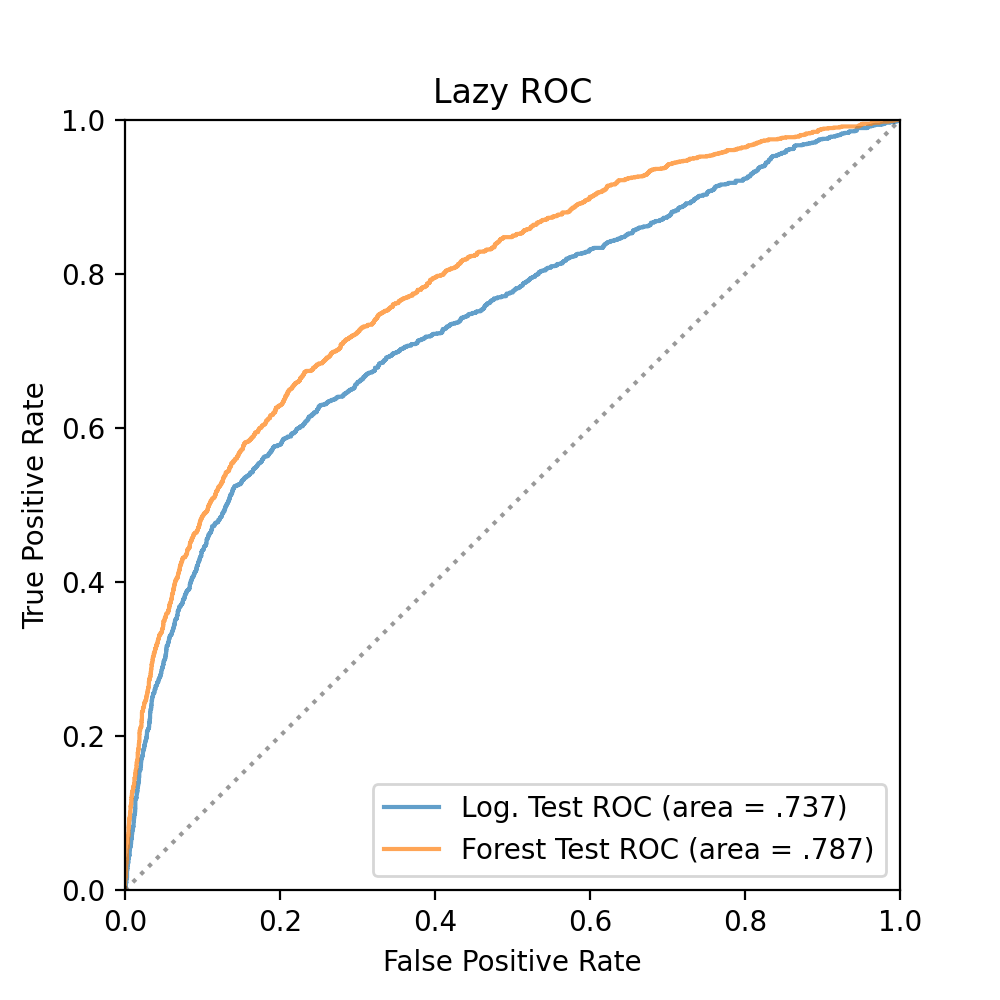

(0.0, 1.0)

In [57]:
#to increase legibility, I'm only including the ROC curves for the test data.

%matplotlib notebook
plt.figure(figsize=[5, 5])
#plt.plot(train_roc[0], train_roc[1], alpha=.7, label="Log. Train ROC (area = .746)")
plt.plot(test_roc[0], test_roc[1], alpha=.7, label="Log. Test ROC (area = .737)")
#plt.plot(f_train_roc[0], f_train_roc[1], alpha=.7, label="Forest Train ROC (area = .890)")
plt.plot(f_test_roc[0], f_test_roc[1], alpha=.7, label="Forest Test ROC (area = .787)")
plt.plot([0,1], [0,1], color="black", alpha=.4, linestyle=":")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lazy ROC")
plt.xlim(0, 1)
plt.ylim(0, 1)



<b>Interpreting the Models</b>

The data for the logistic regression has been heavily processed. However, we can look at what the most important coefficients are, and look at the main features contributing to the relevant components. 

It will also turn out that we can train a Logistic Regression Model in only two of the PCA dimensions. This two-dimensional model has performance and coefficients (for those two dimensions) very similar to those of the original model. This model is more interpretable, in that we can give a visual representation of the decision boundary it uses for separating the data.

We can then identify the most important features in both the Forest and Logistic Regression models.

In [58]:
estimator = gridsearch.best_estimator_

coef_size = np.argsort(abs(estimator.coef_[0]))[::-1]

coef_size

array([ 1,  2, 14,  6, 20,  5, 18, 15, 19, 17, 13, 10,  4,  8,  0, 16,  3,
       12,  9,  7, 11])

In [59]:
estimator.coef_[0][coef_size]

array([ 0.41797203, -0.33893364,  0.21868626,  0.19826401,  0.15753633,
       -0.1543944 ,  0.13225976, -0.11063036, -0.08588732, -0.07878855,
       -0.06885864, -0.06154717,  0.06050438,  0.03324812, -0.0180145 ,
       -0.01645543, -0.01428136, -0.01159953, -0.00391063, -0.00359318,
       -0.00080657])

<b>Exploring a 2D Model</b>

Further exploration also shows that the coefficients of a 2d logistic regression model are very close to the coefficients on the same two dimensions in the 21d model. This allows us to get a visual approximation of how the model separates the data.

In [60]:
lr_2d = LogisticRegression(solver="saga", random_state=12)

params_2d ={"C": [.001, .01, .1, 1, 10, 100, 1000], "class_weight": [None, "balanced"]}

gridsearch_2d = GridSearchCV(estimator=lr_2d, param_grid=params_2d, scoring="roc_auc")

gridsearch_2d.fit(X_train_pca[:, (1,2)], y_train)

gridsearch_2d.cv_results_

{'mean_fit_time': array([0.02203321, 0.02443767, 0.02214212, 0.02356262, 0.02330103,
        0.02383518, 0.02053757, 0.02299218, 0.02161155, 0.02904029,
        0.02305031, 0.02398863, 0.0250874 , 0.02361727]),
 'std_fit_time': array([0.0018057 , 0.00159273, 0.00367694, 0.00229421, 0.00318638,
        0.00136144, 0.00199207, 0.00072456, 0.00103547, 0.00509671,
        0.003485  , 0.00085681, 0.00686377, 0.00075071]),
 'mean_score_time': array([0.00211644, 0.00197582, 0.00187626, 0.00187497, 0.00206604,
        0.00213609, 0.00200038, 0.00187635, 0.0021832 , 0.00249305,
        0.00215406, 0.00210576, 0.00231881, 0.002075  ]),
 'std_score_time': array([1.20475623e-04, 7.14020298e-05, 2.32237809e-05, 4.50383740e-05,
        2.61394632e-05, 2.80915774e-05, 1.90774222e-04, 4.08697014e-05,
        2.74760961e-04, 7.44269405e-04, 1.67314501e-04, 6.28272359e-05,
        3.66401852e-04, 7.76079979e-05]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100,
    

In [61]:
gridsearch_2d.score(X_test_pca[:, (1,2)], y_test), np.mean(gridsearch_2d.predict(X_test_pca[:, (1,2)])==y_test)

(0.7284659058335592, 0.6831372549019608)

In [62]:
#Coefficients for the 21d model are .417 and -.339. This is pretty close to what we observe
#here.

estimator_2d = gridsearch_2d.best_estimator_

w1, w2 = estimator_2d.coef_[0][0], estimator_2d.coef_[0][1]

w1, w2

(0.41795508884709914, -0.3460159254308927)

<IPython.core.display.Javascript object>


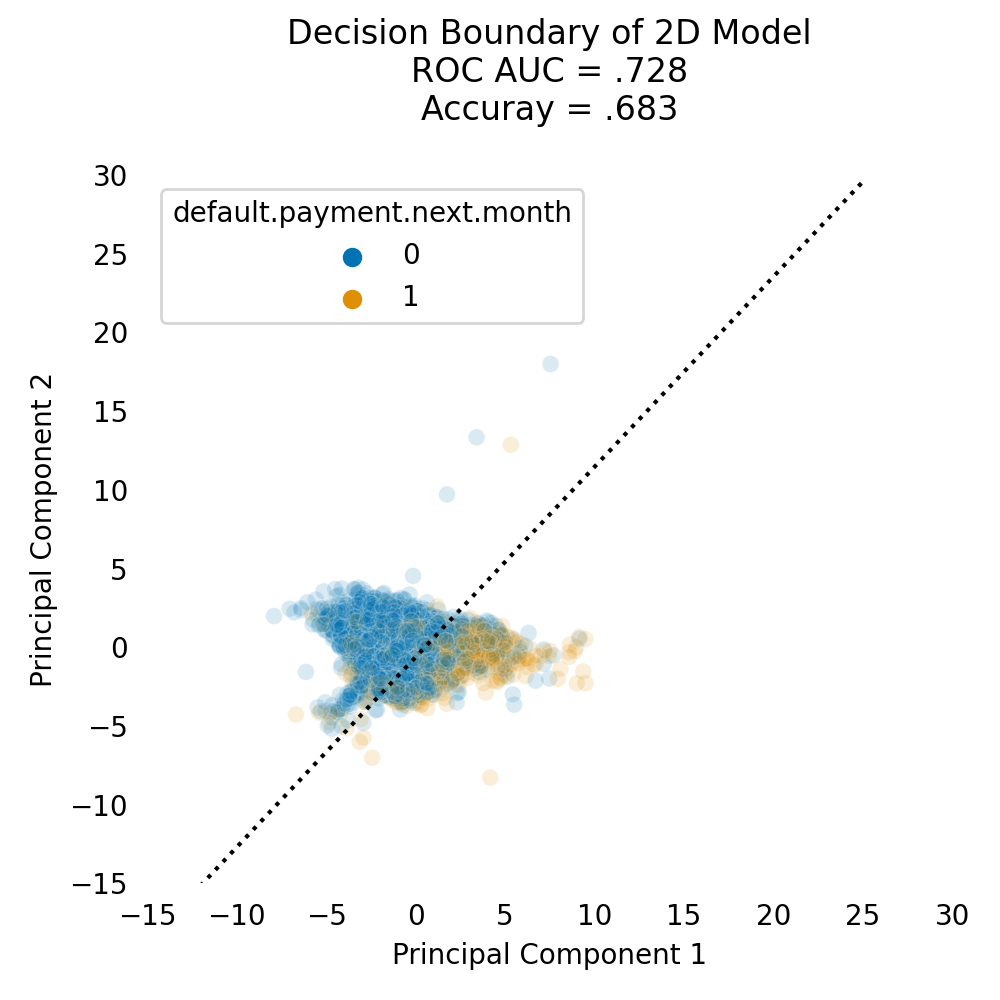

In [63]:

b = estimator_2d.intercept_[0]

xline = np.linspace(-15, 25, 1000)

yline = -(w1 * xline +b)/w2

fig, ax = plt.subplots(figsize=(5, 5))

t=sns.color_palette("colorblind", as_cmap=True)

sns.scatterplot(x=X_test_pca[:, 1], y=X_test_pca[:, 2], hue=y_test, alpha=.15, palette=t[:2], ax=ax)
plt.plot(xline, yline, color="black", linestyle=":")
plt.box(False)
plt.title("Decision Boundary of 2D Model\nROC AUC = .728\nAccuray = .683\n")
plt.tick_params(left=False, bottom=False)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(-15, 30)
plt.ylim(-15, 30)
plt.tight_layout()
#plt.savefig("decision_boundary.png", dpi=300)

<b>ROC vs. Accuracy</b>

We can see in the 2D approximation how the model sacrifices raw accuracy--slicing off a sizeable chunk of blue points--in order to achieve a better ROC score.

<b>Identifying Important Features</b>

We can select the top five features for both of the most heavily weighted principal components to see which of our original categories are most predictive of defaulting.

In [64]:
component1_order = np.argsort(abs(pca.components_[1]))[::-1]

component2_order = np.argsort(abs(pca.components_[2]))[::-1]

In [65]:
list(zip(X.columns[component1_order][:5], pca.components_[1][component1_order][:5]))

[('PAY_2', 0.34703572615007877),
 ('PAY_3', 0.3448124771779981),
 ('LIMIT_BAL', -0.34293679905966773),
 ('PAY_4', 0.33340237583033494),
 ('PAY_0', 0.329761368122473)]

In [66]:
list(zip(X.columns[component2_order][:5], pca.components_[2][component2_order][:5]))

[('PAY_AMT6', 0.30011765090023285),
 ('PAY_AMT3', 0.29872508309112494),
 ('PAY_AMT4', 0.29525231284441766),
 ('PAY_AMT2', 0.2906162919140741),
 ('PAY_AMT5', 0.2832755531877546)]

In [67]:
best_forest = gridsearch2.best_estimator_
important = best_forest.feature_importances_

<IPython.core.display.Javascript object>


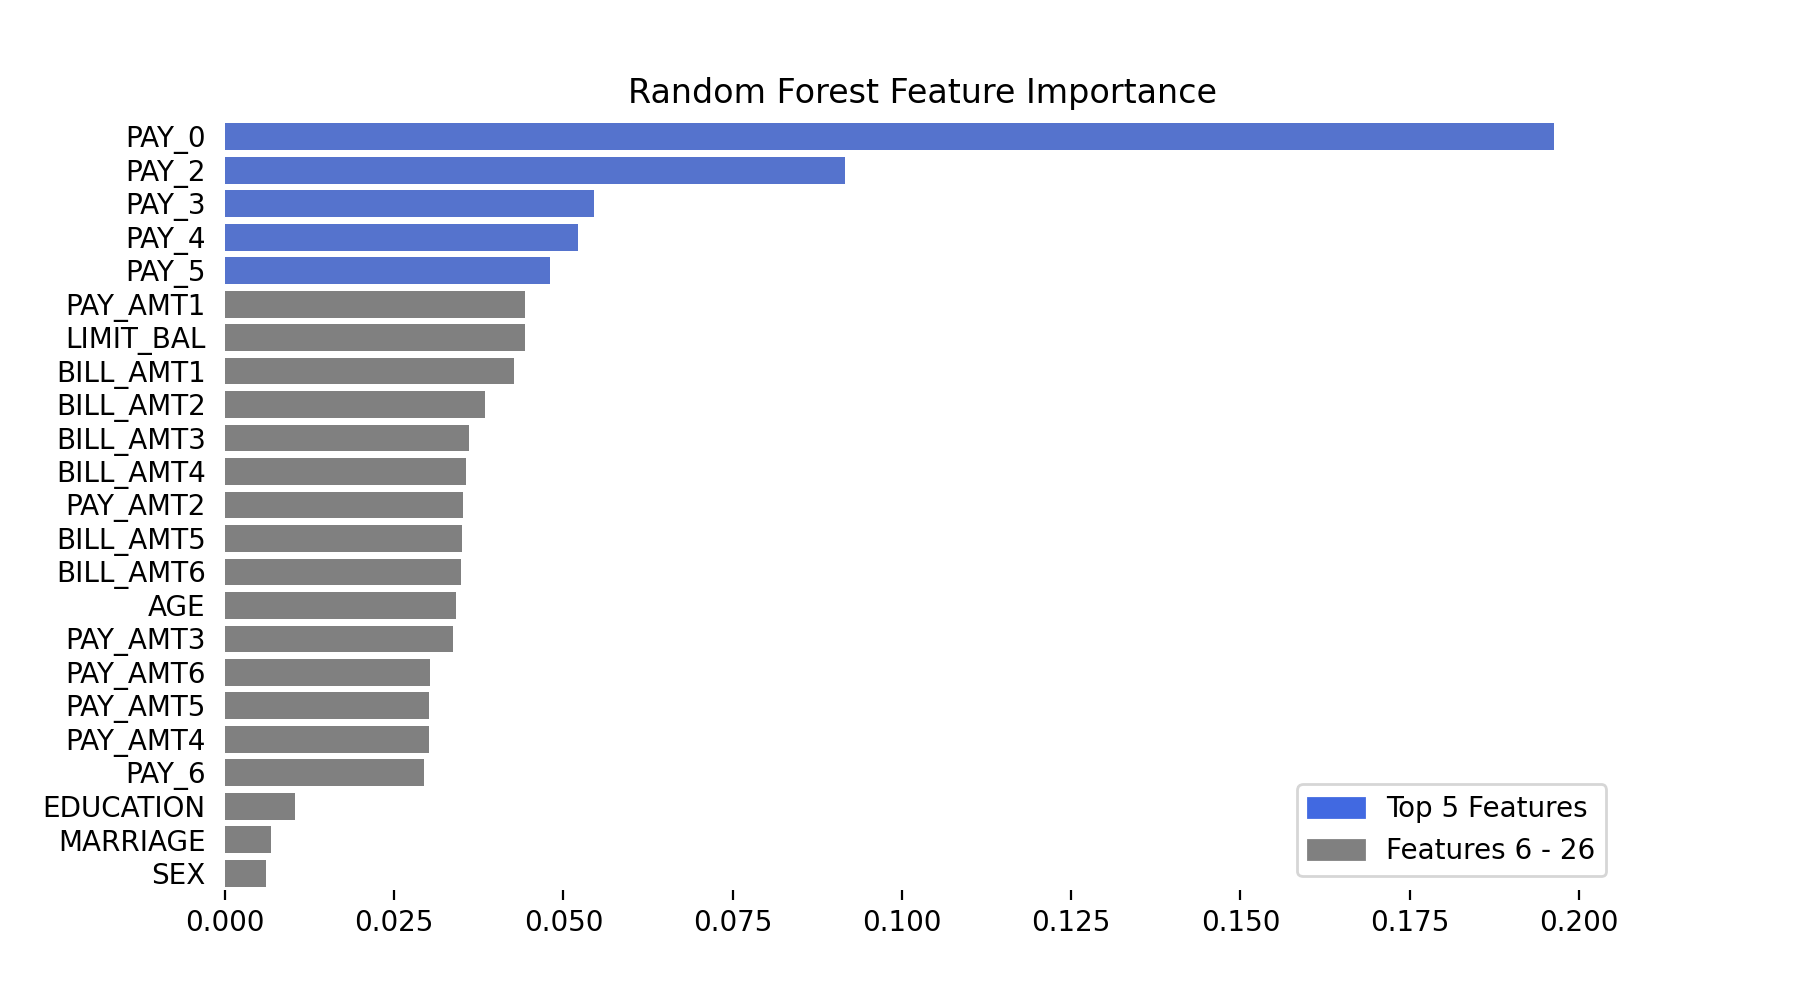

In [68]:
%matplotlib notebook

from matplotlib import patches as mpatches

plt.figure(figsize=(9,5))
k = np.argsort(important)
top_five = ["royalblue"]*5 + ["gray"]*21

sns.barplot(x=important[k][::-1], y=X_train.columns[k][::-1], palette=top_five)
plt.tick_params(left=False)
handles = [mpatches.Patch(color=shade) for shade in set(top_five)]
plt.legend(handles, ["Top 5 Features", "Features 6 - 26"])
plt.title("Random Forest Feature Importance")
plt.box(False)




<b>Reflection</b>

First, the data is not terrible. Questions about whether this is a representative sample of credit card users remain, and some of the data is hard to make sense of. However, after minimal preprocessing a linear model can make predictions with an ROC curve with nearly 3/4 of the area under the curve, and predictive accuracy slightly higher than always picking 0 (roughly 80% vs. 77.8%). A Random Forest performs even better. It has an area under the ROC curve of .787 (in the test case) and predictive accuracy of 81.4%.

The baseline is already relatively high. On the other hand, there are obvious ways to improve on some of the features here. And the high baseline gives reason to believe the data isn't meaningless. Let's see how much higher we can get these scores.

An additional issue is interpretability. Because of the preprocessing of data in the Logistic Regression, the model will not be easy to interpret. This suggests two ways to go: (1) aim at models with better true positive/false positive trade offs, or (2) aim at models that are more easily interpreted. I will attempt both.

<b>What We Know So Far</b>

The models agree that the best predictor of defaulting is, unsurprisingly, being behind in payments. The size of one's credit limit is also important. The Logistic Model gives us a bit more information: LIMIT_BAL has a negative relationship to defaulting. People who qualify for more credit are less likely to default.

The Random Forest treats the size of the credit card bill as highly predictive, whereas the Logistic Regression model does not. It seems likely that this is because the size of the bill, while important, does not bear a linear relationship to defaulting. A large bill can mean the customer has lots of money, and so has little risk of defaulting. It can also mean they are spending beyond their means. The Logistic Regression model treats the amount paid as more important--again, it makes sense that this variable would bear a more linear relationship to the outcome.



<b>Steps in Feature Engineering</b>

The most obvious changes needed are:

1. Change SEX, EDUCATION and MARRIAGE into categorical data.

2. PAY_{X} data combines two kinds of data. It records an amount (how many months is the customer behind in their payments). It also records two kinds of categorical data. -1 means the customer has fully paid their bill. -2 means the customer has no balance for the month. This information sould be separated into different categories.

3. Renaming some column headings would make the table more readable.

After that, I will make the following further changes:

(1) the gap each month between the amount paid and the amount owed, (2) the size of that gap as a proportion of the total credit limit, and (3) the total amount owed by the customer after 6 months, as a proportion of their total credit limit.

<b>Putting the Changes in a Single Function</b>

While the original changes involved quite a bit of scripting, I am placing all the changes in a single function in order to make the presentation more concise, and to make it easier to reapply these changes to new data, such as the "hermetically_sealed_data," if needed.


In [4]:
def data_processing(df):
    
    df1 = df.copy()
    df1.drop(columns="ID", inplace=True)
    df1.rename(columns={"LIMIT_BAL": "card_limit", "SEX": "sex", "AGE": "age", "PAY_0": "PAY_1",
                   "default.payment.next.month":"defaulted"}, inplace=True)
    
    
    df1.sex = df1.sex - 1
    
    #set EDUCATION values as categorical.
    edu_dummies = pd.get_dummies(df1.EDUCATION)
    edu_dummies.rename(columns={0:"edu_other_1", 1:"postgraduate", 2:"undergraduate", 3:"high_school", 4:"edu_other_2",
                            5:"edu_other_3", 6:"edu_other_4"}, inplace=True)
    df1 = df1.merge(edu_dummies, left_index=True, right_index=True)
    df1.drop(columns="EDUCATION", inplace=True)
    
    #set MARRIAGE value as categorical.
    marriage_dummies = pd.get_dummies(df1.MARRIAGE)
    marriage_dummies.rename(columns={0:"other_marital", 1: "married", 2: "single", 3: "divorced"}, inplace=True)
    df1 = df1.merge(marriage_dummies, left_index=True, right_index=True)
    df1.drop(columns="MARRIAGE", inplace=True)
    
    #Separate out values of -1 (balance paid) and -2 (no balance) from months late in PAY_{X} values.
    for N in range(1, 7):
        df1[f"no_balance_{N}"] = df1[f"PAY_{N}"].apply(lambda x: 1 if x==-2 else 0)
        df1[f"paid_balance_{N}"] = df1[f"PAY_{N}"].apply(lambda x: 1 if x==-1 else 0)
        df1[f"PAY_{N}"].replace({-2: 0, -1: 0}, inplace=True)
        pay_cols = [f"PAY_{n}" for n in range(1,7)] + [f"no_balance_{n}" 
                                                       for n in range(1, 7)] + [f"paid_balance_{n}" for
                                                                                n in range(1, 7)]
    
    #Determine gap between bill and payment for each month, and proportion of credit limit left unpaid.
    for N in range(1, 7):
        df1[f"gap_{N}"] = df1[f"BILL_AMT{N}"] - df1[f"PAY_AMT{N}"]
        df1[f"proportion_gap_{N}"] = df1[f"gap_{N}"] / df1.card_limit
    gap_cols = [f"gap_{n}" for n in range(1, 7)] + [f"proportion_gap_{n}" for n in range(1, 7)]
    
    df1["total_proportions"] = df1[[f"proportion_gap_{n}" for n in range(1,7)]].sum(axis=1)
    
    #reorder the columns for legibility
    df1 = df1[["card_limit", "sex", "age", "edu_other_1", "edu_other_2", "edu_other_3", "edu_other_4", 
        "postgraduate", "undergraduate", "high_school", "other_marital", "married", "single", "divorced"]
       + pay_cols + [f"BILL_AMT{N}" for N in range(1, 7)] + [f"PAY_AMT{N}" for N in range(1, 7)]
      + gap_cols + ["total_proportions"] + ["defaulted"]]

    X = df1.drop(columns="defaulted")
    y = df1.defaulted
    
    return (X, y)

In [6]:
X2, y2 = data_processing(starting_data)

<b>Correlations with Target</b>

We can compare the correlations of the improved features with those of our target. In some cases, for example the PAY_{X} columns, the values are higher.

In [71]:
X2.merge(y2, left_index=True, right_index=True).corr()["defaulted"]

card_limit          -0.151570
sex                 -0.042854
age                  0.013946
edu_other_1         -0.010025
edu_other_2         -0.023555
edu_other_3         -0.036057
edu_other_4         -0.007698
postgraduate        -0.053401
undergraduate        0.034782
high_school          0.036510
other_marital       -0.012628
married              0.030156
single              -0.030577
divorced             0.007528
PAY_1                0.394923
PAY_2                0.324759
PAY_3                0.284189
PAY_4                0.268572
PAY_5                0.264284
PAY_6                0.245937
no_balance_1        -0.065331
no_balance_2        -0.031213
no_balance_3        -0.030435
no_balance_4        -0.023664
no_balance_5        -0.020315
no_balance_6        -0.019535
paid_balance_1      -0.061980
paid_balance_2      -0.077024
paid_balance_3      -0.081355
paid_balance_4      -0.074635
paid_balance_5      -0.070015
paid_balance_6      -0.060173
BILL_AMT1           -0.018550
BILL_AMT2 

<b>Further Questions about the Data</b>

Investigating some further properties of the data reveals additional irregularities. The customer base, as a whole, has vastly exceeded the official credit limits (see below). For example, the median customer has cumulative charges-over-payments total equal to 1.4 times their official credit limit. More than 10% of customers have balances exceeding five times their credit limit. One customer has incurred debt over 31 times their credit limit.

This raises two obvious problems with the data:

<b>This is further evidence that we have a non-representative sample.</b> The customers in this dataset could be those who were selected as being at higher risk of default. Exceeding one's credit limit would be an obvious cause for concern.

<b>Is this data accurate?</b> Did a customer actually manage to ring up a balance of 31 times their credit limit? Why wouldn't the credit card cut them off? One possibility is that the credit card did cut the customer off, and they are being charged for overdraft fees and interest. This is consistent with the size of the BILL_AMT{X} that we see for this customer (see below). The bills get progressively larger each month. (Remember the months are recorded backwards, with "1" representing September and "6" representing April.)

I will conclude provisionally that the data is (more or less) accurate but unrepresentative, in order to complete the project. In real life, this would be the time for further investigation to confirm both assumptions.

In [72]:
X2.total_proportions.head()

0    0.350750
1    0.100642
3    4.458920
4    1.005800
5    4.606840
Name: total_proportions, dtype: float64

In [73]:
#Over 54% of customers have exceeded their credit balance
total_proportions = X2.total_proportions

(total_proportions > 1).mean()

0.5403529411764706

<IPython.core.display.Javascript object>


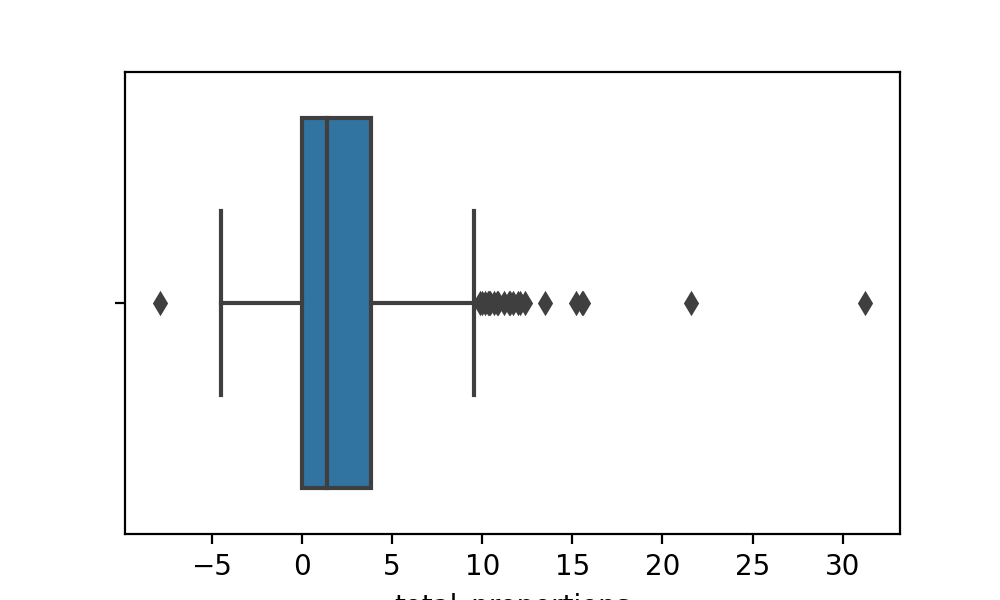

<AxesSubplot:xlabel='total_proportions'>

In [74]:
%matplotlib notebook
plt.figure(figsize=(5,3))
sns.boxplot(x = total_proportions)

In [75]:
#The median customer has a debt equal to 1.4 times their limit. 
#Over 10% of customers have debt equal to 5x their credit!

total_proportions.median(), (total_proportions>5).mean(), (total_proportions>10).mean()

(1.4144677749360615, 0.10698039215686274, 0.000784313725490196)

In [76]:
total_proportions.describe()

count    25500.000000
mean         2.003922
std          2.050741
min         -7.857394
25%          0.028564
50%          1.414468
75%          3.826735
max         31.221350
Name: total_proportions, dtype: float64

In [77]:
(total_proportions>10).sum()

20

In [78]:
worst = X2[total_proportions == total_proportions.max()]
worst

card_limit  sex  age  edu_other_1  edu_other_2  edu_other_3  \
3796     20000.0    1   32            0            0            0   

      edu_other_4  postgraduate  undergraduate  high_school  ...    gap_4  \
3796            0             0              1            0  ...  99737.0   

        gap_5    gap_6  proportion_gap_1  proportion_gap_2  proportion_gap_3  \
3796  95625.0  75711.0            6.2343             6.198            5.2354   

      proportion_gap_4  proportion_gap_5  proportion_gap_6  total_proportions  
3796           4.98685           4.78125           3.78555           31.22135  

[1 rows x 57 columns]

In [79]:
#According to this the customer continues to pay their minimum balance due each month.

pay_cols2 = [f"PAY_{x}" for x in range(1,7)]

worst[pay_cols2]

PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6
3796      0      0      0      0      0      0

In [80]:
#They never defaulted?

y2.loc[3796]

0

In [81]:
worst[[f"BILL_AMT{N}" for N in range(1,7)] + [f"PAY_AMT{N}" for N in range(1,7)]]

BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
3796   129106.0   127610.0   107828.0   102937.0    98525.0    77711.0   

      PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
3796    4420.0    3650.0    3120.0    3200.0    2900.0    2000.0

In [8]:
#checking out delinquency rate (more than 30 days late) for each month
#delinquency rates range from 9.9% to 14.7%. This is vastly higher than delinquency rates in the US:
#https://fred.stlouisfed.org/series/DRCCLACBS

delinquency = {}
for N in range(1, 7):
    rate = len(X2[X2[f"PAY_{N}"]>1])/len(X2)
    delinquency[f"MONTH_{N}"] = rate
    
delinquency

{'MONTH_1': 0.10372549019607843,
 'MONTH_2': 0.14721568627450982,
 'MONTH_3': 0.1403921568627451,
 'MONTH_4': 0.11713725490196078,
 'MONTH_5': 0.09925490196078432,
 'MONTH_6': 0.10380392156862744}

<b>Creating Models - High Scoring Models</b>

The goal in this subsection will be to see if comparable models (Logistic Regression and Random Forest) can be trained on the new data with higher ROC and accuracy scores than the previous models. Interpretability at this point is not a concern.

I will work on training a more easily interpreted Logistic Regression model afterwards.

<IPython.core.display.Javascript object>


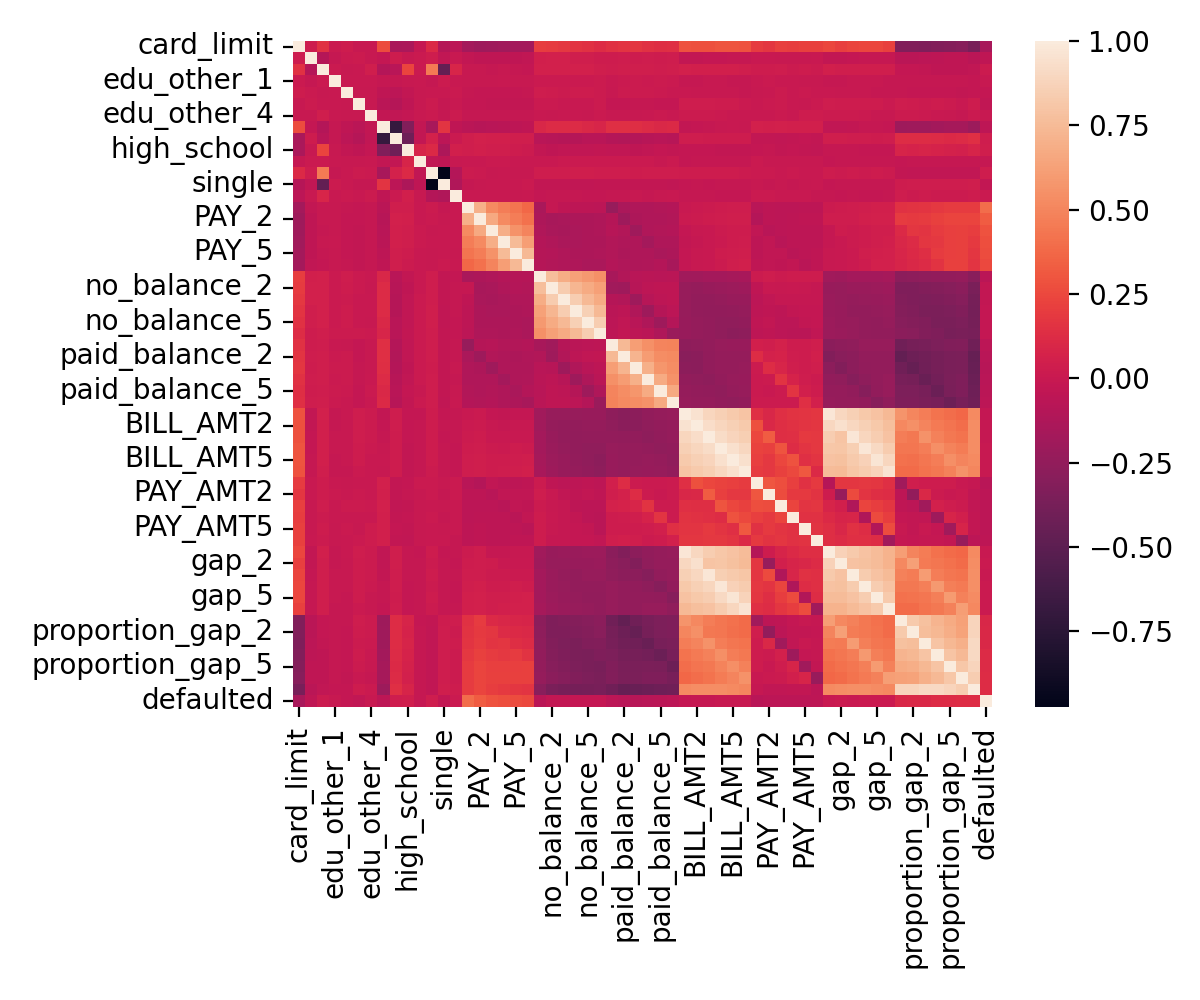

In [82]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(X2.merge(y2, right_index=True, left_index=True).corr())
plt.tight_layout()

<b>Building a Preprocessing + Logistic Regression Object</b>

I am comparing multiple models, all of which need different kinds of preprocessing. In order to make it easier to keep track of everything, I am going to build an object which contains both the Logistic Regression object and the preprocessing objects, and handles everything internally. Again, this will help with legibility, and also make it easier to make sure I am correctly applying the model to any new data, such as the "hermetically_sealed_data".

In [83]:
class Heavily_Processed_Regressor:
    def __init__(self, random_state1=None, random_state2=None):
        
        from sklearn.preprocessing import PowerTransformer, StandardScaler
        from sklearn.decomposition import PCA
        from sklearn.linear_model import LogisticRegression
        
        self.lr = LogisticRegression(solver="liblinear", random_state=random_state1)
        self.pca = PCA(.98)
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer()
        self.random_state = random_state2
    
    def fit(self, X, y):
        from sklearn.model_selection import train_test_split, GridSearchCV
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=self.random_state)
        
        self.numeric2 = X.nunique()[X.nunique() != 2].index
        self.X_train[self.numeric2] = self.transformer.fit_transform(self.X_train[self.numeric2])
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_train = self.pca.fit_transform(self.X_train)
        
        self.X_test[self.numeric2] = self.transformer.transform(self.X_test[self.numeric2])
        self.X_test = self.scaler.transform(self.X_test)
        self.X_test = self.pca.transform(self.X_test)
        self.grid = GridSearchCV(estimator = self.lr, 
                                 param_grid = {"penalty": ["l1", "l2"], "C":[.001, .01, .1, 1, 10, 100, 1000],
                                              "class_weight": [None, "balanced"]},
                                scoring="roc_auc")
        
        self.grid.fit(self.X_train, self.y_train)
        
        return self.grid.cv_results_
    
    def get_scores(self):
        train_score = self.grid.score(self.X_train, self.y_train)
        train_acc = np.mean(self.grid.predict(self.X_train)==self.y_train)
        test_score = self.grid.score(self.X_test, self.y_test)
        test_acc = np.mean(self.grid.predict(self.X_test)==self.y_test)
        
        return {"train roc auc": train_score, "train accuracy": train_acc,
               "test roc auc": test_score, "test accuracy": test_acc}
    
    def get_roc(self):
        from sklearn.metrics import roc_curve
        probs = self.grid.predict_proba(self.X_test)[:,1]
        return roc_curve(self.y_test, probs)
    
    def score(self, X, y):
        Xobj = X.copy()
        Xobj[self.numeric2] = self.transformer.transform(Xobj[self.numeric2])
        Xobj = self.scaler.transform(Xobj)
        Xobj = self.pca.transform(Xobj)
        
        return {"roc auc": self.grid.score(Xobj, y),
               "accuracy": np.mean(self.grid.predict(Xobj)==y)}
    
    def calculate_roc(self, X, y):
        from sklearn.metrics import roc_curve
        Xobj = X.copy()
        Xobj[self.numeric2] = self.transformer.transform(Xobj[self.numeric2])
        Xobj = self.scaler.transform(Xobj)
        Xobj = self.pca.transform(Xobj)
        probs = self.grid.predict_proba(Xobj)[:,1]
        
        return roc_curve(y, probs)
    

In [84]:
heavy_lr = Heavily_Processed_Regressor(random_state1=81, random_state2=31)

heavy_lr.fit(X2, y2)

{'mean_fit_time': array([0.03451304, 0.08994055, 0.03257079, 0.06549487, 0.04063869,
        0.10072575, 0.03523684, 0.09818177, 0.05022664, 0.12950525,
        0.04900804, 0.12505794, 0.0591826 , 0.13233376, 0.07582965,
        0.12796636, 0.13312721, 0.15231194, 0.18621936, 0.17230525,
        0.20305262, 0.16835818, 0.24924026, 0.14400082, 0.21586423,
        0.15211062, 0.25210991, 0.18060074]),
 'std_fit_time': array([0.00582925, 0.01127884, 0.00215886, 0.00068204, 0.00278968,
        0.00850113, 0.00043555, 0.00766194, 0.00434169, 0.00440571,
        0.00736558, 0.00283901, 0.0100152 , 0.00467009, 0.00185787,
        0.00272956, 0.01019048, 0.01310018, 0.02118567, 0.02620656,
        0.02909318, 0.02476906, 0.04359751, 0.01285189, 0.0308963 ,
        0.01524196, 0.04930579, 0.05458495]),
 'mean_score_time': array([0.00219941, 0.00284309, 0.00223804, 0.00208607, 0.00270033,
        0.00244217, 0.00207782, 0.00341725, 0.00222254, 0.00241256,
        0.00223112, 0.00226707, 0.003333

In [85]:
heavy_lr.get_scores()

{'train roc auc': 0.7717502390914865,
 'train accuracy': 0.7529411764705882,
 'test roc auc': 0.7731740705654553,
 'test accuracy': 0.7527843137254902}

In [86]:
heavy_lr.grid.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [87]:
test_roc2 = heavy_lr.get_roc()

<IPython.core.display.Javascript object>


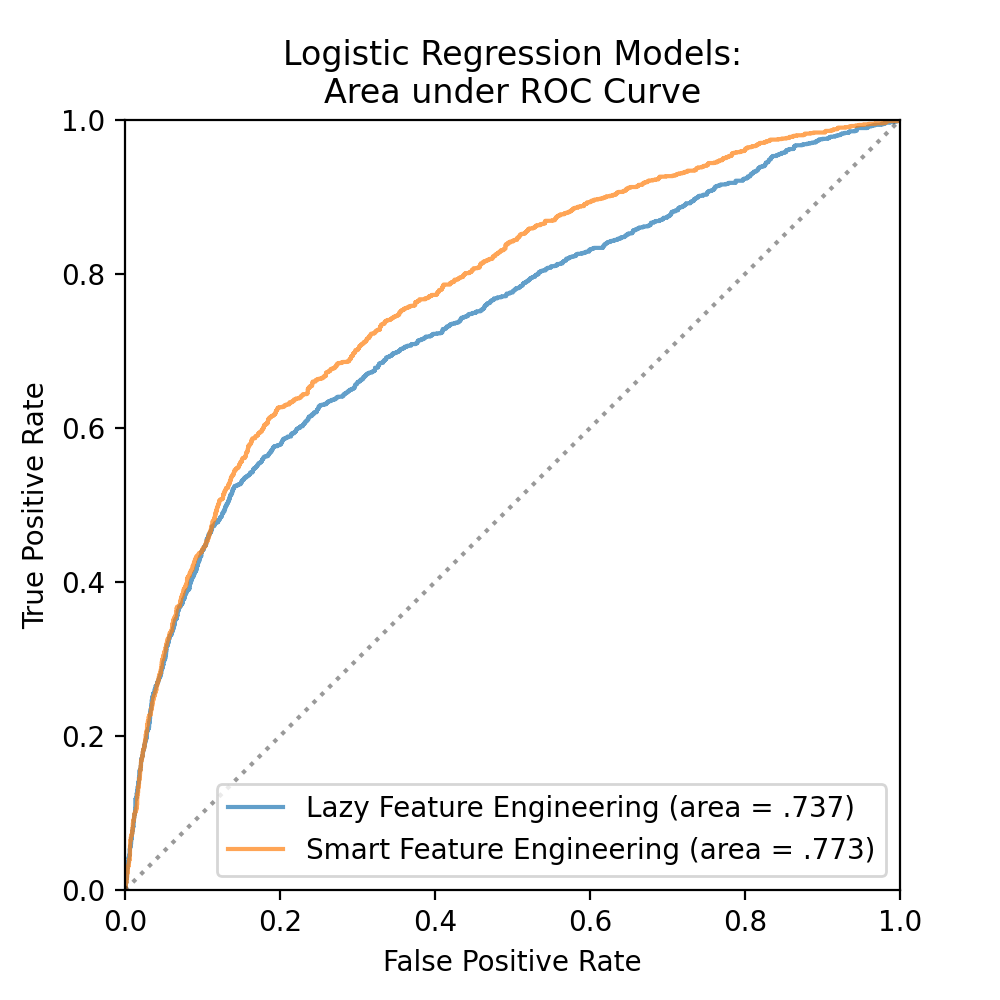

In [90]:

plt.figure(figsize=[5, 5])
plt.title("Logistic Regression Models:\nArea under ROC Curve")
plt.plot(test_roc[0], test_roc[1], alpha=.7, label="Lazy Feature Engineering (area = .737)")
plt.plot(test_roc2[0], test_roc2[1], alpha=.7, label="Smart Feature Engineering (area = .773)")
plt.plot([0,1], [0,1], color="black", alpha=.4, linestyle=":")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
#plt.savefig("log_reg_roc.png", dpi=300)

In [91]:
heavy_coefs = heavy_lr.grid.best_estimator_.coef_

heavy_coef_order = np.argsort(abs(heavy_coefs[0]))[::-1]
heavy_coef_order

array([ 1,  3, 32, 37, 34,  2,  5, 25, 39, 28,  7,  8, 26, 19, 40, 29, 22,
       11, 21,  9, 17, 30, 10, 27, 35, 31, 20, 13, 12,  0,  4, 23,  6, 38,
       24, 14, 16, 18, 15, 33, 36])

In [92]:
heavy_coefs[0][heavy_coef_order]

array([ 0.30167459,  0.29525269, -0.22939896, -0.18893348, -0.17842784,
       -0.16570227, -0.15708435,  0.15688805,  0.13262767, -0.12677179,
       -0.11247777, -0.08922943, -0.08703085, -0.0859384 ,  0.08192567,
       -0.07794669,  0.07595844, -0.07537279,  0.07403344, -0.06600622,
        0.06188634, -0.05817293,  0.05613456, -0.05223415, -0.04605856,
        0.0421643 ,  0.03253474, -0.03114455, -0.03081391, -0.02547059,
        0.01986383, -0.01927523, -0.01643797,  0.01446656, -0.01441989,
       -0.01113265, -0.01066417, -0.01022058, -0.00937529, -0.00684038,
       -0.00344158])

In [93]:
#heavy_lr.pca.explained_variance_ratio_

<IPython.core.display.Javascript object>


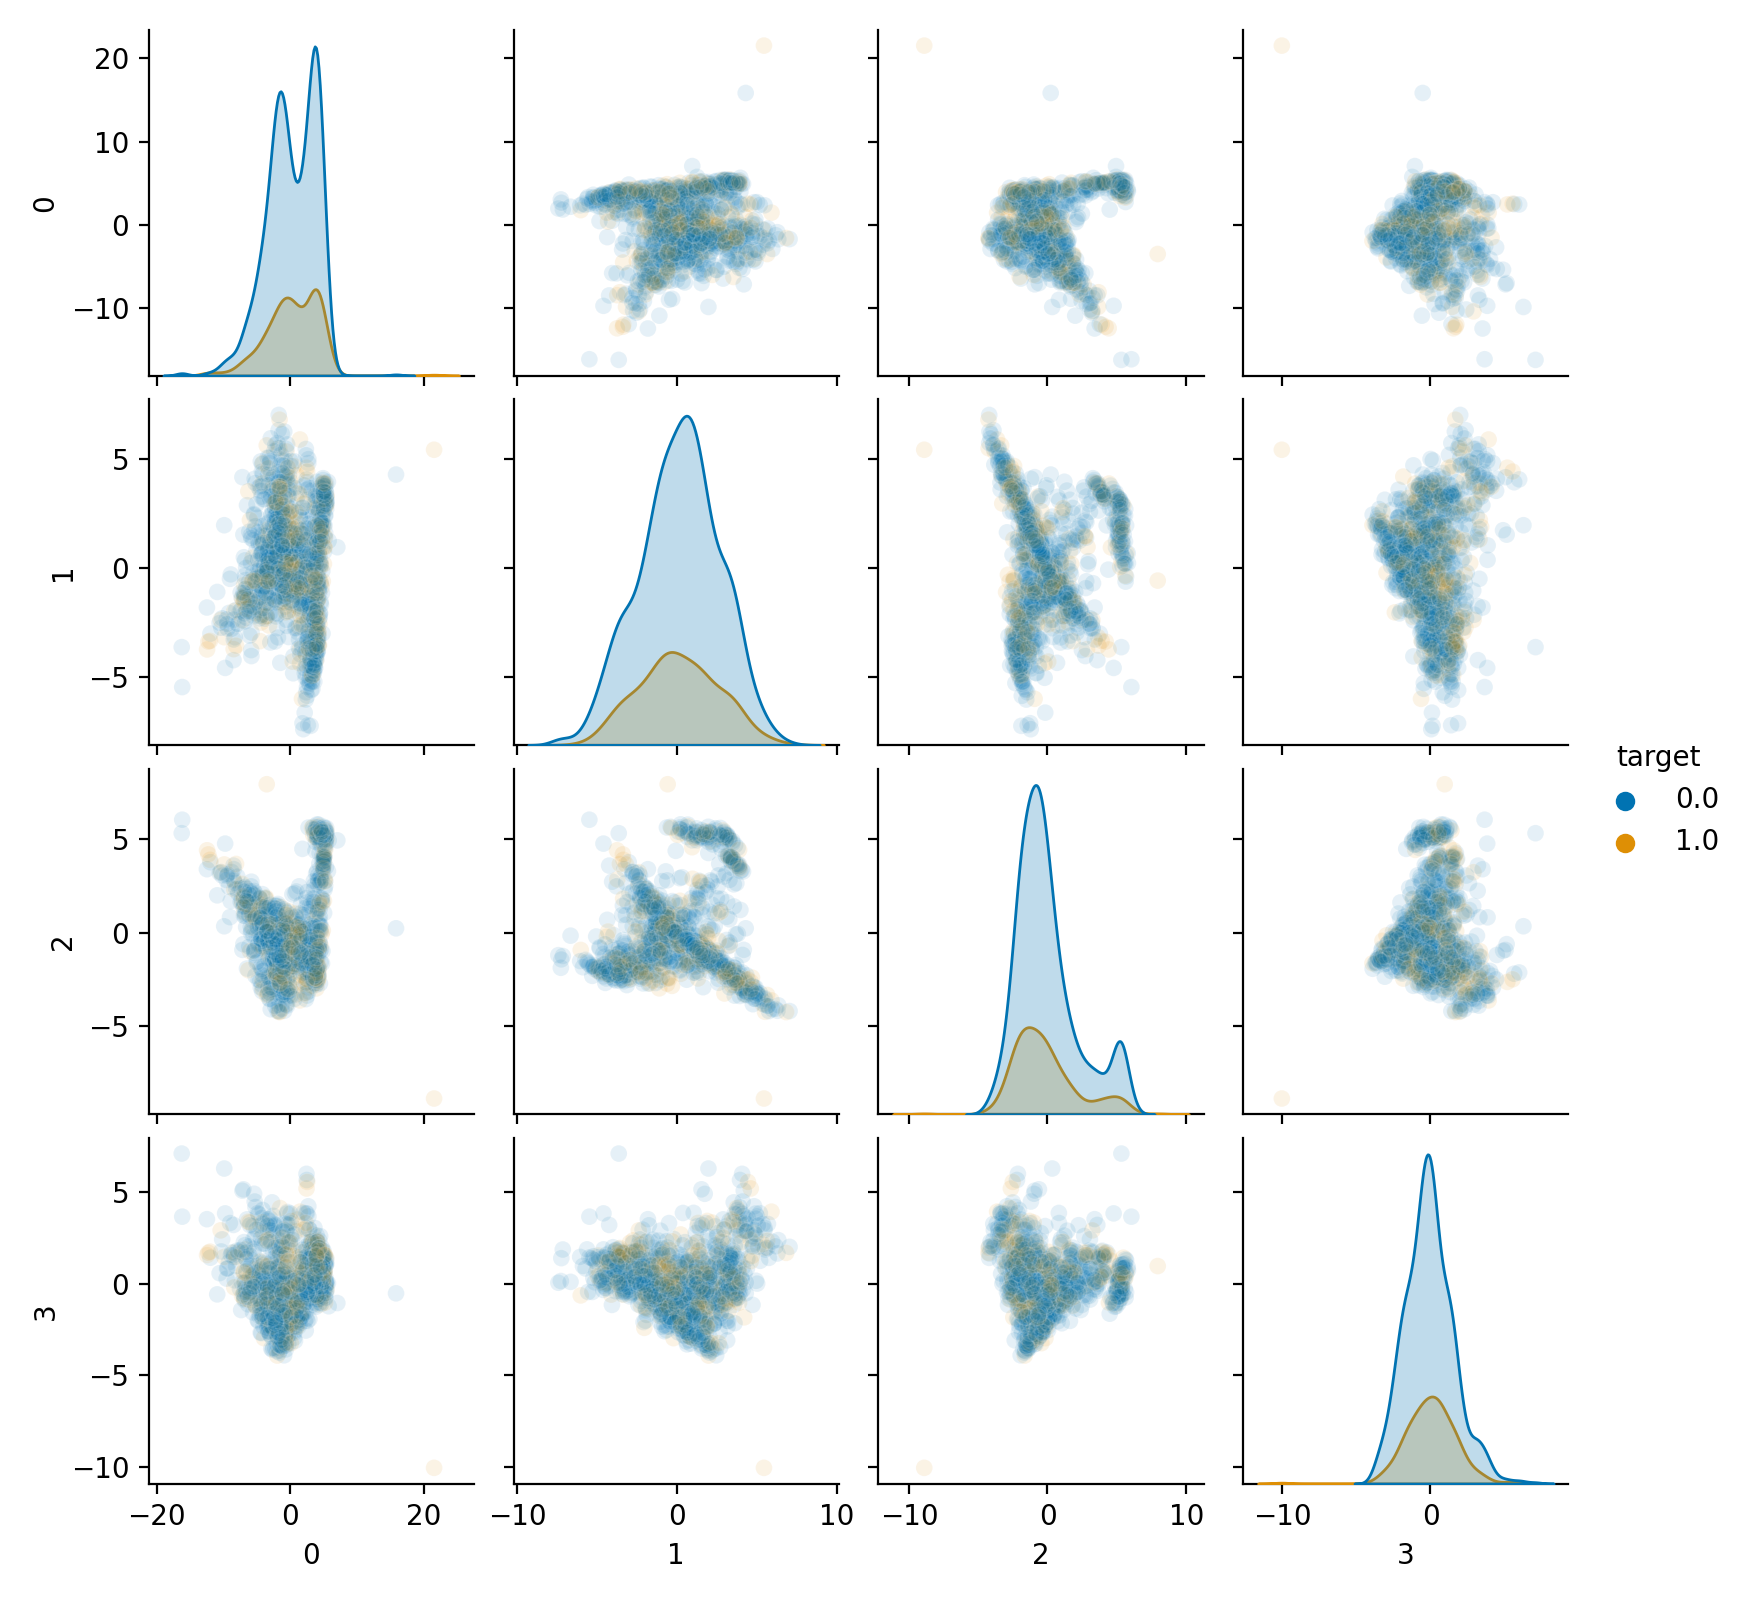

In [94]:

pairplot_data = pd.DataFrame(heavy_lr.X_test[:, (0, 1, 2, 3)], columns = [0, 1, 2, 3])
pairplot_data["target"] = heavy_lr.y_test

sns.pairplot(data=pairplot_data, hue="target", kind="scatter", plot_kws={"alpha":.1}, palette=t[:2], height=2)

<b>No clean separation</b>

Unlike the application of PCA to the earlier version of the data, we no longer get relatively clean separation of the target values along two dimensions. The graphs are kind of pretty, though.

In [95]:
#Finding the features with the most impact on the model. Again, this will mean taking the two
#most heavily-weighted components and checking their top features.

features_hv = X2.columns

comp1_hv = heavy_lr.pca.components_[1]
order1_hv = np.argsort(comp1_hv)[::-1]

list(zip(features_hv[order1_hv][:8], comp1_hv[order1_hv][:8]))

[('PAY_1', 0.19699602968823826),
 ('PAY_2', 0.1951322177808584),
 ('PAY_4', 0.18815193917948492),
 ('PAY_3', 0.18740128527166902),
 ('PAY_5', 0.1804232762116414),
 ('PAY_6', 0.16130865375755732),
 ('total_proportions', 0.13606873985046075),
 ('proportion_gap_3', 0.12274989856486206)]

In [96]:
comp3_hv = heavy_lr.pca.components_[3]
order3_hv = np.argsort(comp3_hv)[::-1]

list(zip(features_hv[order3_hv][:8], comp3_hv[order3_hv][:8]))

[('PAY_5', 0.28225161056568027),
 ('PAY_4', 0.2806733146049443),
 ('PAY_2', 0.2798371065401702),
 ('PAY_3', 0.2794860746852618),
 ('PAY_1', 0.2688262045929791),
 ('PAY_6', 0.25387056565628685),
 ('married', 0.24044497616294708),
 ('card_limit', 0.22872371931025734)]

In [97]:
heavy_lr.grid.best_estimator_.coef_

array([[-0.02547059,  0.30167459, -0.16570227,  0.29525269,  0.01986383,
        -0.15708435, -0.01643797, -0.11247777, -0.08922943, -0.06600622,
         0.05613456, -0.07537279, -0.03081391, -0.03114455, -0.01113265,
        -0.00937529, -0.01066417,  0.06188634, -0.01022058, -0.0859384 ,
         0.03253474,  0.07403344,  0.07595844, -0.01927523, -0.01441989,
         0.15688805, -0.08703085, -0.05223415, -0.12677179, -0.07794669,
        -0.05817293,  0.0421643 , -0.22939896, -0.00684038, -0.17842784,
        -0.04605856, -0.00344158, -0.18893348,  0.01446656,  0.13262767,
         0.08192567]])

The model is responding mostly to how late the customer is with their payments.

In [98]:
# comparison with Random Forest

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=31)

classifier2 = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=21)
grid_params4 = {"max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15], "class_weight": [None, "balanced"]}

gridsearch4 = GridSearchCV(estimator=classifier2, param_grid=grid_params4, scoring="roc_auc")

gridsearch4.fit(X2_train, y2_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                              random_state=21),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]},
             scoring='roc_auc')

In [99]:
gridsearch4.best_params_

{'class_weight': None, 'max_depth': 11}

In [100]:
gridsearch4.cv_results_

{'mean_fit_time': array([1.05506477, 0.94700527, 1.18642974, 1.37473669, 1.74869599,
        1.71283388, 1.67645679, 1.72448897, 1.83248825, 2.35293255,
        0.84487529, 0.95882592, 1.1067728 , 1.2045857 , 1.57777462,
        1.44642568, 1.55211029, 1.60749574, 1.7612637 , 2.00001597]),
 'std_fit_time': array([0.43022721, 0.09103526, 0.14443899, 0.1245042 , 0.17632685,
        0.10653684, 0.06686128, 0.03668664, 0.07109398, 0.38835771,
        0.02273452, 0.0229504 , 0.05793998, 0.03412641, 0.5215419 ,
        0.03497462, 0.05625298, 0.00645833, 0.05154925, 0.04272482]),
 'mean_score_time': array([0.06642179, 0.06035237, 0.06360664, 0.07890658, 0.07784357,
        0.07553291, 0.06116414, 0.06220684, 0.06229491, 0.07685761,
        0.0595911 , 0.05864229, 0.0607657 , 0.05973201, 0.05882444,
        0.06320963, 0.06023521, 0.06093559, 0.06304717, 0.06464319]),
 'std_score_time': array([0.01130473, 0.00161026, 0.00467806, 0.02413962, 0.01297596,
        0.02151605, 0.00156169, 0.002076

In [101]:
#Getting ROC AUC score for training data

gridsearch4.score(X2_train, y2_train)

0.9052881846637254

In [102]:
#Getting accuracy for training data

np.mean(gridsearch4.predict(X2_train)==y2_train)

0.874718954248366

In [103]:
#ROC score on test data

gridsearch4.score(X2_test, y2_test)

0.7877573022772077

In [104]:
#ROC accuracy

np.mean(gridsearch4.predict(X2_test)==y2_test)

0.8185098039215686

In [105]:

f_test_probs2 = gridsearch4.predict_proba(X2_test)[:,1]

f_test_roc2 = roc_curve(y2_test, f_test_probs2)

<IPython.core.display.Javascript object>


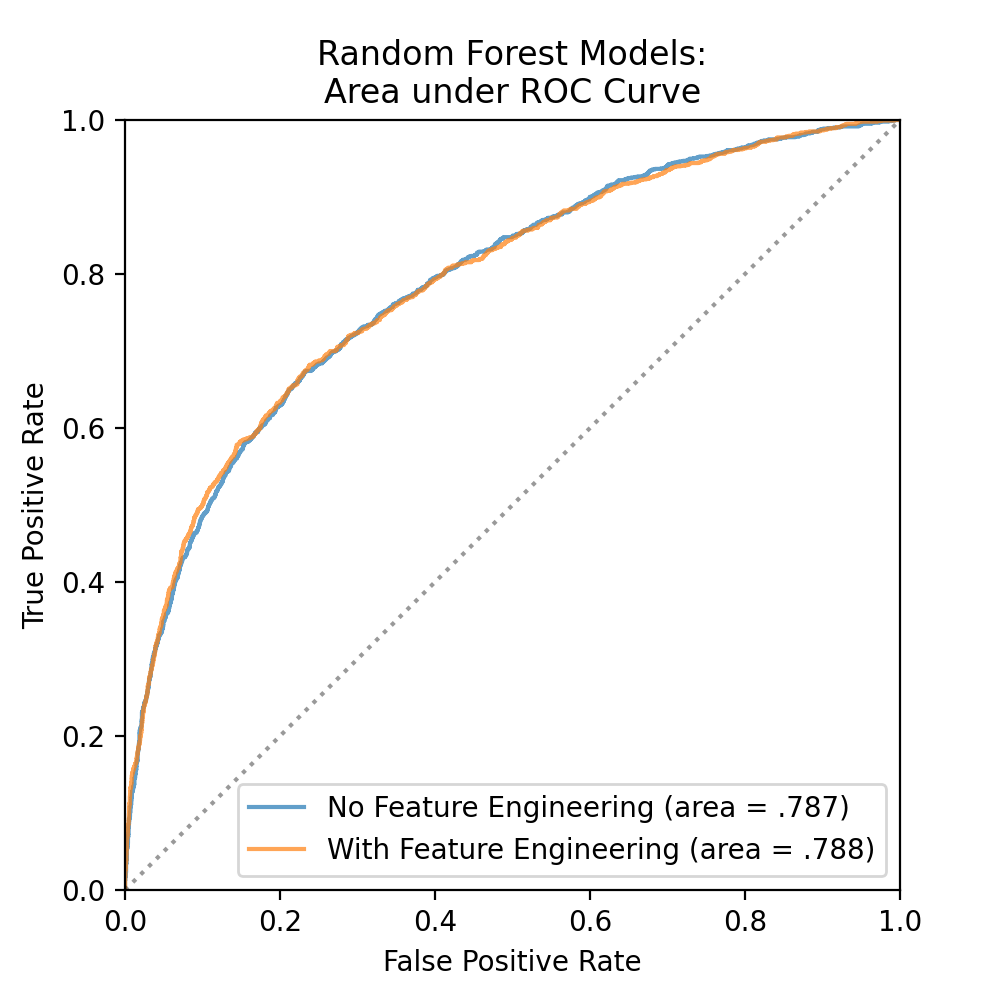

(0.0, 1.0)

In [106]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(f_test_roc[0], f_test_roc[1], alpha=.7,
        label="No Feature Engineering (area = .787)")
ax.plot(f_test_roc2[0], f_test_roc2[1], alpha=.7,
        label="With Feature Engineering (area = .788)")
ax.plot([0,1], [0,1], color="black", alpha=.4, linestyle=":")
ax.legend(loc="lower right")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.title("Random Forest Models:\nArea under ROC Curve")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#plt.savefig("r_forest_models.png", dpi=300)

In [107]:
best_forest2 = gridsearch4.best_estimator_

important2 = best_forest2.feature_importances_

<IPython.core.display.Javascript object>


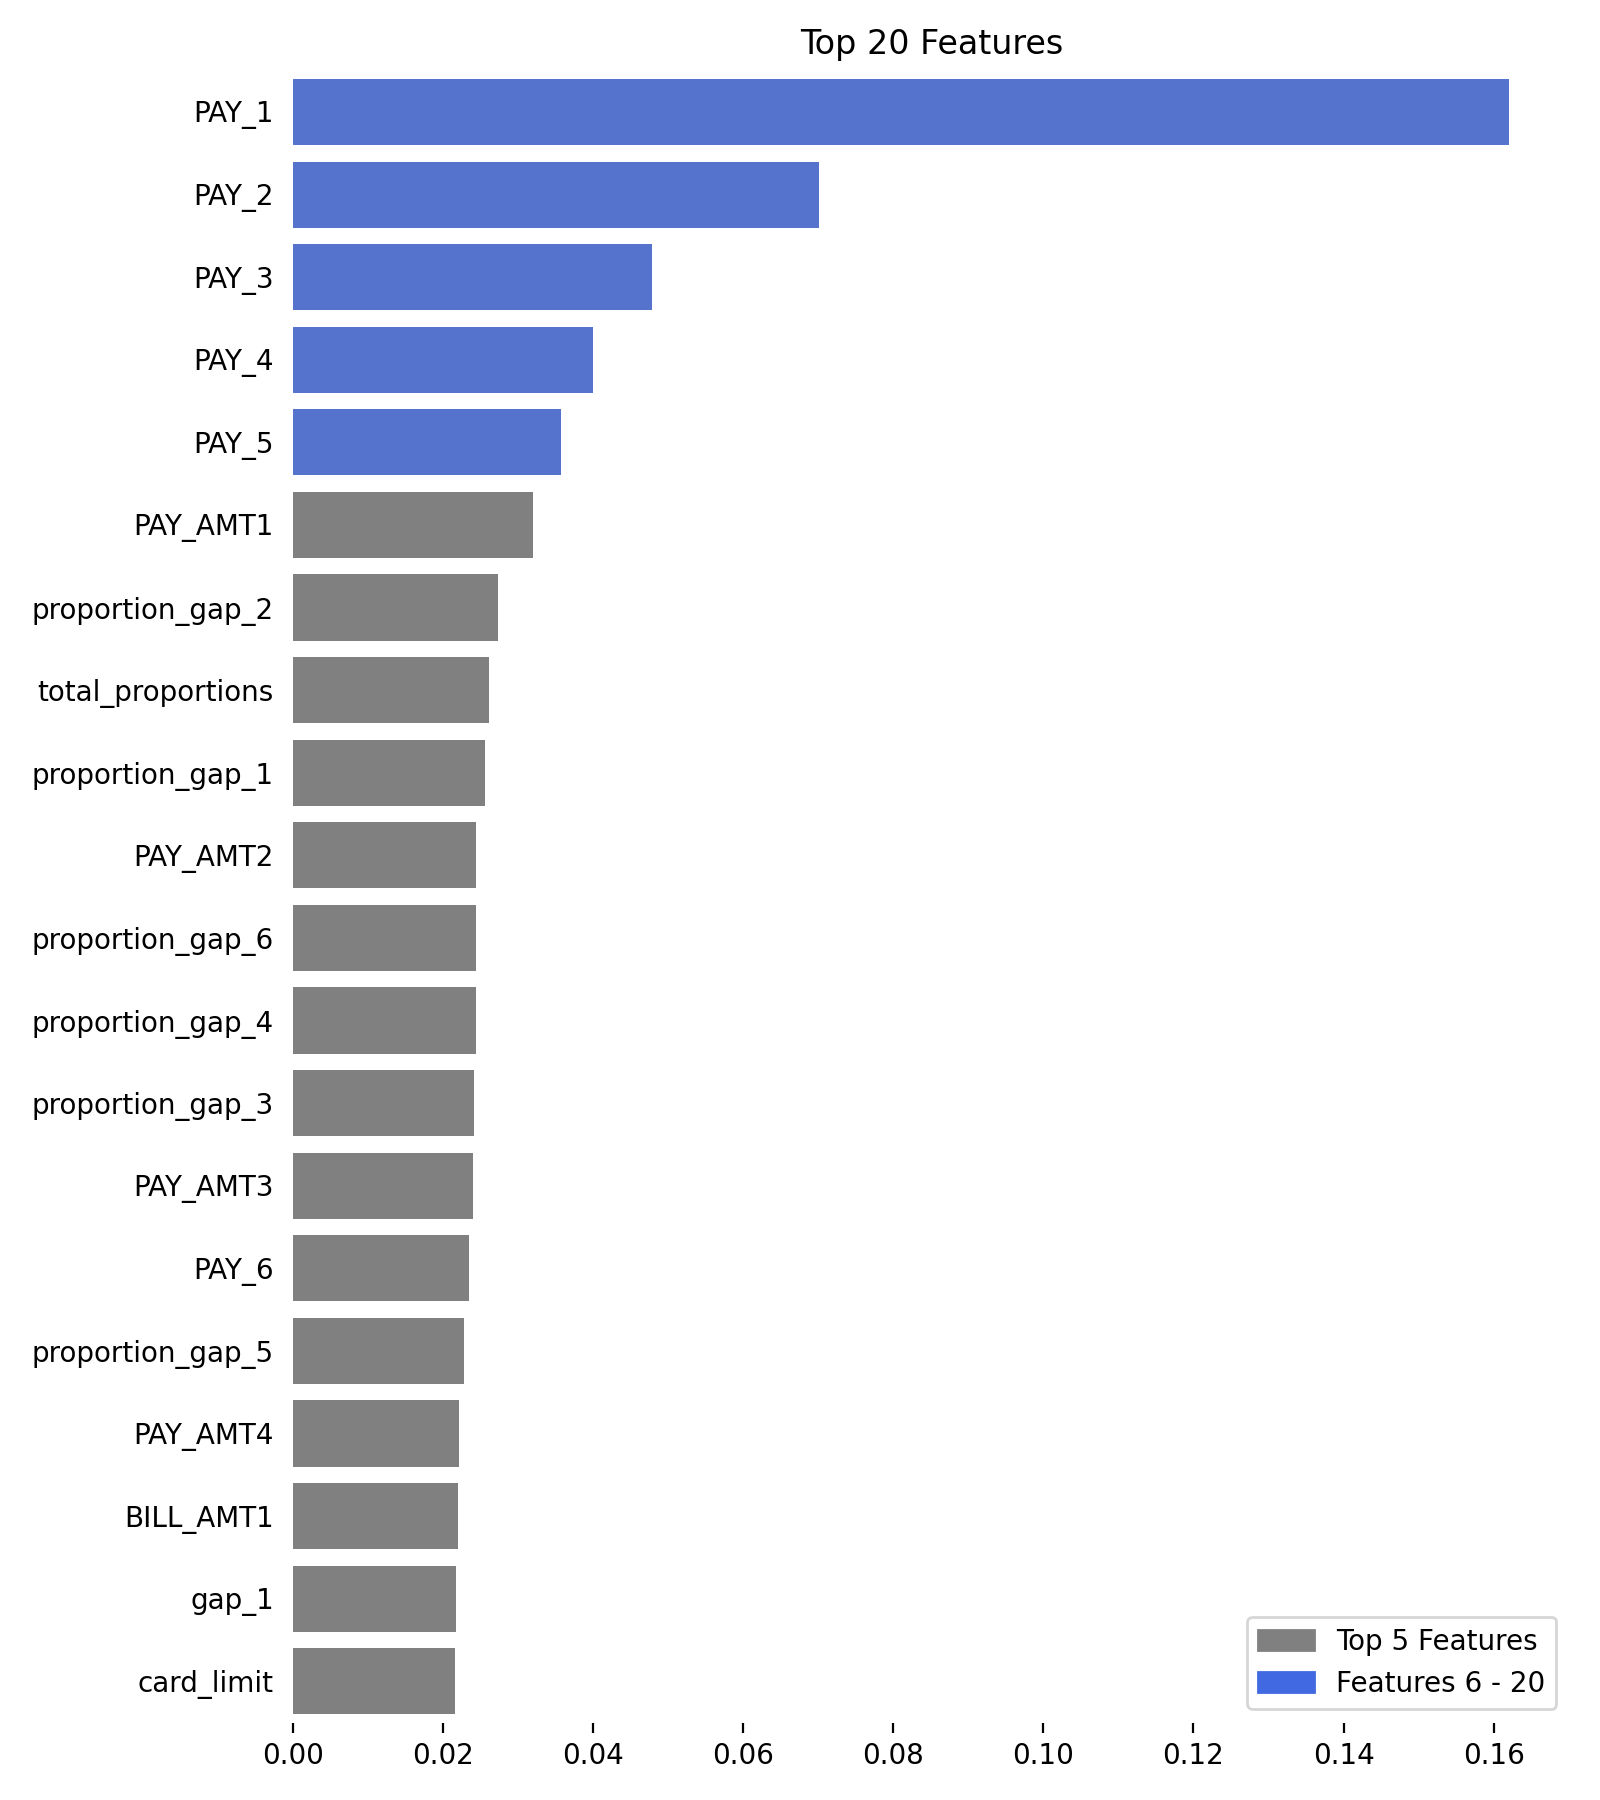

In [108]:
%matplotlib notebook
plt.figure(figsize=(8, 9))
k2 = np.argsort(important2)
top_five2 = ["royalblue"]*5 + ["grey"]*30


sns.barplot(x=important2[k2][37:][::-1],
            y=X2_train.columns[k2][37:][::-1], palette=top_five2)
plt.tick_params(left=False)
plt.box(False)
plt.title("Top 20 Features")
handles = [mpatches.Patch(color=shade) for shade in set(top_five2)]
plt.legend(handles, ["Top 5 Features", "Features 6 - 20"])
plt.tight_layout()
plt.savefig("top_features.png", dpi=200)

<b>Reflection on New Models</b>

The results here are mixed. Feature engineering brought about a moderate improvement in Logistic Regression. Area under the ROC curve increased from .737 to .773.

With the random forest models, feature engineering did not improve performance. The area under the ROC curve is effectively the same (.787 vs. .788) as is accuracy (.814 vs. .818). This is probably because the majority of the feature engineering was aimed at correcting representations of data that a linear system would be likely to misinterpret. A value of "-2" in one of the PAY{X} columns, for example, did not mean that the bill was paid 2 months early. But a decision tree would not assume that it meant that.

Are there ways to engineer features to help the Random Forest, rather than a linear model? I attempted both cutting out features that were not useful to the Random Forest, as well as adding in features representing <b>important binary decision points</b>. For example, I tried a model trained with features such as whether a customer had missed a payment (1 = "yes", 0 = "no"). The score of the forests was more or less the same. (I have not included these attempts here, because the project is already quite long.)

The Random Forest is the best predictor; however, it was slower to train than the Logistic Regression model. In terms of interpretability, the two models are fairly similar. They seem to agree that being behind in payments is the primary predictor of defaulting.


<b>Time to Verify the Models</b>

Now it is time to look at the data we sealed off at the beginning, and double check model performance against that data. This will also provide a chance to write functions for the sort of the data-cleaning each of the Models requires. I will do this for the Random Forest Model, the heavily-processed Logistic Regression Model, and the final interpretable Logistic Regression Model.

In [109]:
X_sealed, y_sealed = data_processing(hermetically_sealed_data)

In [110]:
X_sealed.head()

card_limit  sex  age  edu_other_1  edu_other_2  edu_other_3  \
10172    410000.0    1   48            0            0            0   
24003     20000.0    0   27            0            0            1   
11635    160000.0    1   27            0            0            0   
4173     200000.0    0   48            0            0            0   
2109      60000.0    1   22            0            0            0   

       edu_other_4  postgraduate  undergraduate  high_school  ...    gap_4  \
10172            0             0              0            1  ...  -5535.0   
24003            0             0              0            0  ...  18809.0   
11635            0             1              0            0  ...  -1535.0   
4173             0             0              1            0  ...      0.0   
2109             0             0              1            0  ...  12207.0   

         gap_5    gap_6  proportion_gap_1  proportion_gap_2  proportion_gap_3  \
10172    729.0  14296.0         -0.090837          0.065120          0.013934   
24003  20113.0  19840.0          1.083650          1.052550          1.022000   
11635   1718.0  -2487.0         -0.016244          0.008150         -0.003625   
4173       0.0      0.0          1.025750          0.000000          0.000000   
2109   17744.0   6242.0          0.178633         -0.540783         -0.040883   

       proportion_gap_4  proportion_gap_5  proportion_gap_6  total_proportions  
10172         -0.013500          0.001778          0.034868           0.011363  
24003          0.940450          1.005650          0.992000           6.096300  
11635         -0.009594          0.010738         -0.015544          -0.026119  
4173           0.000000          0.000000          0.000000           1.025750  
2109           0.203450          0.295733          0.104033           0.200183  

[5 rows x 57 columns]

In [111]:
#testing the Random Forest Classifier on the Validation Set

gridsearch4.score(X_sealed, y_sealed), np.mean(gridsearch4.predict(X_sealed)==y_sealed)

(0.7818678920943292, 0.8211111111111111)

In [112]:
#testing Logistic Regression with heavy data processing

heavy_lr.score(X_sealed, y_sealed)

{'roc auc': 0.7721195773267404, 'accuracy': 0.7506666666666667}

<b>Models Verified</b>

Scores are more or less the same.

<b>Final Evaluation</b>



In [113]:
results = {"Random Forest": [.788, .782, .819, .821], 
           "Logistic Regression":[.772, .772, .753, .751]}

columns = ["ROC_AUC_test", "ROC_AUC_valid", "Accuracy_test", "Accuracy_valid"]

metrics = pd.DataFrame.from_dict(columns=columns, data=results, orient="index")
metrics

ROC_AUC_test  ROC_AUC_valid  Accuracy_test  \
Random Forest               0.788          0.782          0.819   
Logistic Regression         0.772          0.772          0.753   

                     Accuracy_valid  
Random Forest                 0.821  
Logistic Regression           0.751

In [114]:
forest_probs = gridsearch4.predict_proba(X_sealed)[:,1]
roc1 = roc_curve(y_sealed, forest_probs)

roc2 = heavy_lr.calculate_roc(X_sealed, y_sealed)


<IPython.core.display.Javascript object>


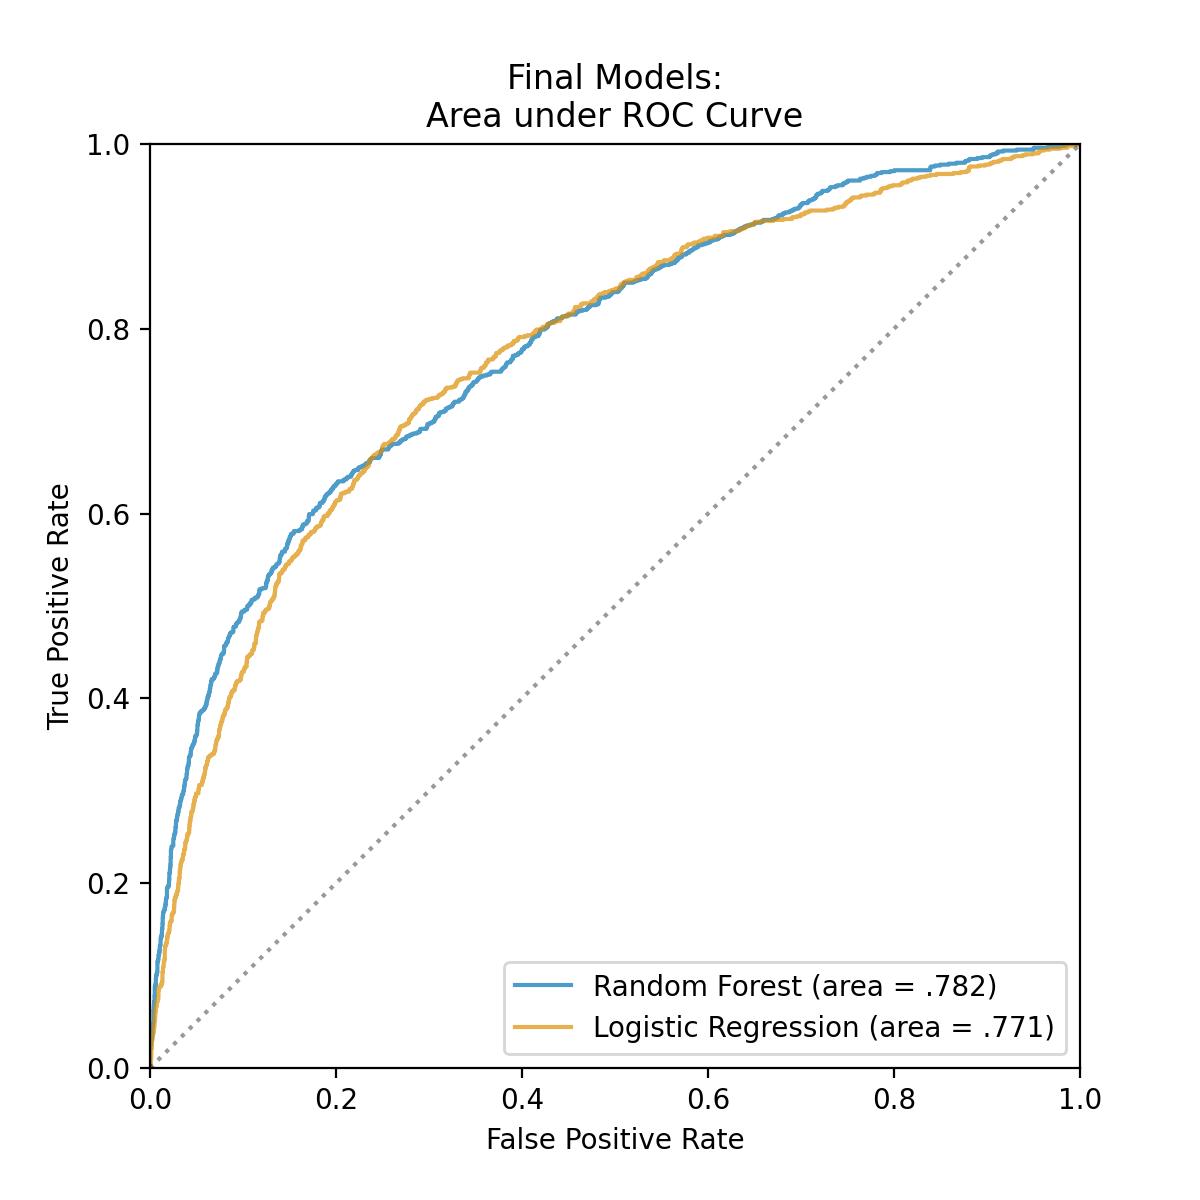

In [118]:
plt.figure(figsize=[6, 6])
plt.title("Final Models:\nArea under ROC Curve")
plt.plot(roc1[0], roc1[1], alpha=.7, color = t[0], label="Random Forest (area = .782)")
plt.plot(roc2[0], roc2[1], alpha=.7, color = t[1], label="Logistic Regression (area = .771)")
plt.plot([0,1], [0,1], color="black", alpha=.4, linestyle=":")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)

#plt.savefig("final_models_roc.png", dpi=300)

<b>Comparing the Models</b>

<b>Random Forest</b> appears to be the optimal model for prediction. It is fairly easy to train (feature engineering turned out to be completely unnecessary). It appears some of the important information in our data bears non-linear relationships to the target feature. (It was noted before that the size of the bills was treated as important by a Random Forest model, but presumably this feature does not bear a linear relationship to the odds of defaulting, because a large bill could be a good sign or a bad one.) The only drawback is the model was a bit slower to train. This did not matter much for a sample size of 30,000. For a larger dataset the Random Forest would probably be impractical, unless we work with a random subsample of the data. But at this size it seems perfect.

<b>Feature Engineering</b> did not add predictive power, given that the Random Forest continued to outperform the linear models. However, with a dataset large enough to make Random Forest prohibitively slow, the feature engineering provided a modest but real improvement to the performance of Logistic Regression.

Where feature engineering paid off is in helping interpretation and in revealing odd features about the data. The PAY_{X} columns mixed different kinds of information about credit card usage. Some of this information was more predictive, other elements less so. We also would not know how heavily the customers have exceeded their credit limits if it weren't for feature engineering.

<b>Reconsidering Problems with the Data</b>

Problems with the data were noted earlier in this project. Some of the data might be inaccurate. It also seems very likely that this is not a random sample of Taiwanese credit card users, but instead a subset of customers who were picked out because they had been flagged as more likely to default.

With respect to the first problem, it seems possible that a more accurate model could be trained after dropping questionable data. However, further investigation suggests this is not the case. Interested readers can see the code below, which drops every row in which the number of months by which a customer is late grows at a speed faster than 1 month per month. This turns out to be a significant portion of the data. However, the resulting Random Forest and Logistic Regression Models effectively tie with models trained on the full dataset.

With respect to the second question, it affects both the applicability of the models and the lessons to take from them. In terms of applicability, the models have been trained on data for which roughly 22% of customers default. If the real rate is, as I suspect, much lower, these models will likely overpredict the risk of default. As an example of how we might learn different things from the data, consider the fact that roughly 60% of the customers in our sample are women. If the dataset is a large random sample, the relevant questions might be, should the company market itself towards women, with whom it already appears to be more popular, or should it start marketing itself toward men, who represent an under-explored market. But if this is not a random sample, the questions are very different ones. It appears that the company is noticeably more likely to flag women customers as being at risk of defaulting. The question, then, is whether the company is overly likely to flag women relative to men, given that a lower percentage of the women in our sample ended up defaulting.

*Note, more reason to suspect that women are being flagged at a disproportionately high rate can be found in Part II of the project.*

<b>Epilogue</b>

For those who are interested, the results of training a Random Forest model on the dataset after dropping cases where the customers seemed to "jump" ahead in how many months late they were with payments is below. The differences in ROC score are minimal, however.

In [141]:
df1, y = data_processing(starting_data)

possible_errors = df1[(df1.PAY_1 > df1.PAY_2 + 1)|(df1.PAY_2 > df1.PAY_3 + 1)|(df1.PAY_3 > df1.PAY_4+1)|
                     (df1.PAY_4 > df1.PAY_5 + 1)|(df1.PAY_5 > df1.PAY_6 +1)]

len(possible_errors), len(df1)

(5026, 25500)

In [142]:
df_corrected = df1[~df1.index.isin(possible_errors.index)]

len(df_corrected)

20474

In [143]:
classifier_cor = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=21)
grid_params_cor = {"max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15], "class_weight": [None, "balanced"]}

gridsearch_cor = GridSearchCV(estimator=classifier_cor, param_grid=grid_params_cor, scoring="roc_auc")

gridsearch_cor.fit(df1, y)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                              random_state=21),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]},
             scoring='roc_auc')

In [144]:
gridsearch_cor.cv_results_

{'mean_fit_time': array([1.11166506, 1.22238898, 1.37951512, 1.65455861, 2.36285706,
        2.44481182, 2.53956566, 3.10207939, 2.57015128, 3.05390911,
        1.15239544, 1.32226043, 1.5105092 , 1.68244619, 1.81273546,
        1.983354  , 2.15757656, 2.3238306 , 2.78275537, 3.47500253]),
 'std_fit_time': array([0.05220971, 0.01092142, 0.08520372, 0.07144822, 0.67418307,
        0.64108732, 0.19136017, 0.90717703, 0.10590552, 0.59859683,
        0.01174271, 0.02661852, 0.03607336, 0.04770731, 0.01362862,
        0.03365676, 0.04090886, 0.07083135, 0.46194783, 0.38739476]),
 'mean_score_time': array([0.08900542, 0.08641248, 0.08691053, 0.10533419, 0.10143194,
        0.10638676, 0.16002049, 0.12781386, 0.1077373 , 0.09828663,
        0.0855628 , 0.08709621, 0.0877244 , 0.08973722, 0.08966284,
        0.09190841, 0.09361377, 0.09106736, 0.10633101, 0.12632046]),
 'std_score_time': array([0.0129796 , 0.00240078, 0.00421775, 0.02905026, 0.02112207,
        0.03266861, 0.08836957, 0.056528

In [145]:
gridsearch_cor.best_params_

{'class_weight': None, 'max_depth': 9}

In [146]:
gridsearch_cor.score(X_sealed, y_sealed), np.mean(gridsearch_cor.predict(X_sealed)==y_sealed)

(0.7829325987848087, 0.8226666666666667)

In [147]:
cor_X_sealed = X_sealed[~((X_sealed.PAY_1 > X_sealed.PAY_2 + 1)|(X_sealed.PAY_2 > X_sealed.PAY_3 + 1)
                          |(X_sealed.PAY_3 > X_sealed.PAY_4+1)|(X_sealed.PAY_4 > X_sealed.PAY_5 + 1)|
                          (X_sealed.PAY_5 > X_sealed.PAY_6 +1))]

cor_y_sealed = y_sealed[y_sealed.index.isin(cor_X_sealed.index)]

gridsearch_cor.score(cor_X_sealed, cor_y_sealed), np.mean(gridsearch_cor.predict(cor_X_sealed)==cor_y_sealed)

(0.7318796499929812, 0.8627724986025712)

In [148]:
cor_lr = Heavily_Processed_Regressor(random_state1=55, random_state2=7)

cor_lr.fit(df1, y)

{'mean_fit_time': array([0.04704723, 0.09417949, 0.04316063, 0.09392848, 0.05528722,
        0.11354017, 0.05172849, 0.11627183, 0.06812124, 0.16780701,
        0.07045836, 0.16170979, 0.11033959, 0.17223988, 0.11403956,
        0.17528281, 0.2737464 , 0.23882775, 0.40768681, 0.23949523,
        0.54623485, 0.21970601, 1.88855109, 0.21997609, 0.45797725,
        0.20502663, 3.43510232, 0.19511533]),
 'std_fit_time': array([3.87738346e-03, 1.87241899e-03, 1.43788104e-03, 3.01735751e-03,
        3.17194260e-03, 2.29758013e-03, 1.78671860e-03, 4.55116809e-03,
        4.57559309e-03, 8.18521095e-03, 5.20183511e-03, 1.60916036e-02,
        1.85154849e-02, 6.85147202e-03, 1.35776477e-02, 9.58150801e-03,
        3.94463245e-02, 1.98671439e-02, 9.62428332e-02, 1.30797206e-02,
        2.24286320e-01, 5.79511177e-03, 2.14674302e+00, 5.43431392e-03,
        1.06143034e-01, 7.56243535e-03, 2.70879474e+00, 5.75346221e-03]),
 'mean_score_time': array([0.00314436, 0.00310831, 0.0028625 , 0.00301371, 

In [149]:
cor_lr.get_scores()

{'train roc auc': 0.7771640992097654,
 'train accuracy': 0.7601568627450981,
 'test roc auc': 0.7571718243867301,
 'test accuracy': 0.7482352941176471}

In [150]:
cor_lr.score(X_sealed, y_sealed)

{'roc auc': 0.7720122119461881, 'accuracy': 0.758}

In [151]:
cor_lr.score(cor_X_sealed, cor_y_sealed)

{'roc auc': 0.7300219924196341, 'accuracy': 0.8018446059250979}